## **Segundo avance del proyecto, tecnicas de inteligencia artificial**

### **Integrantes**

- Oscar Leonardo Riveros Perez

- Yovany Esneider Vargas Gutierrez

**Preproceso, adecuación de imagenes**

In [37]:
import cv2
from IPython.display import Image
import os
import numpy as np
import math
from matplotlib import pyplot as plt
import time

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

#Se tienen 3 tipos de imagen
#Mano al interior
Indoor_P = cv2.imread('Images/Indoor_P.jpg',1)
Indoor_G = cv2.imread('Images/Indoor_G.jpg',1)

#Mano al exterior pero con un patron de ladrillos de fondo
Pattern_P = cv2.imread('Images/Pattern_P.jpg',1)
Pattern_G = cv2.imread('Images/Pattern_G.jpg',1)

#Mano en un ambiente donde hay varios tipos de objetos
Green_P = cv2.imread('Images/Green_P.jpg',1)
Green_G = cv2.imread('Images/Green_G.jpg',1)

#[:,:,::-1] -> Corrección para representar con matplotlib, ya que el arreglo de opencv esta en [B,G,R] y matplotlib [R,G,B]
Green_P, Green_G, Indoor_P, Indoor_G, Pattern_P, Pattern_G = Green_P[:,:,::-1],Green_G[:,:,::-1], Indoor_P[:,:,::-1], Indoor_G[:,:,::-1], Pattern_P[:,:,::-1], Pattern_G[:,:,::-1]

Original_P = [Indoor_P, Pattern_P, Green_P]
Original_G = [Indoor_G, Pattern_G, Green_G]

***Tecnicas de Segmentacion***

La primera etapa para realizar un procesamiento adecuado de la mano, consiste en la segmentacion de la imagen para obtener la region donde se encuentra el objeto a identificar, en este caso las manos.

****Espacios de Color + Otsu****

Uno de los primeros planteamientos sobre la segmentacion de la mano corresponde al analisis en los diferentes espacios de color para encontrar el metodo con el mejor desempeño.

Los espacios de color más son compatibles con el reconocimiento de piel son el HSV y YCrCb. Sin embargo, en un estudio realizado por Michael J. Jones, demuestra que son más relavantes el numero de bins que el espacio de color utilizado en el reconocimiento de la piel, por tanto, también se pondrá a prueba este metodo.

In [38]:
#Funciones
def YCrCb(img):
    return (cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb))

def HSV(img):
    return (cv2.cvtColor(img, cv2.COLOR_RGB2HSV))

def lessBins(img, bins):
    q = 256/bins
    normalized_img = cv2.normalize(img, None, 0, bins-1, cv2.NORM_MINMAX)
    return(normalized_img)

def dilarode(img, kernel):
    dilated_img = cv2.dilate(img, kernel, iterations = 1)
    dilaroded_img = cv2.erode(dilated_img, kernel, iterations = 1)
    return(dilaroded_img)

El tiempo de ejecucion del umbral Otsu es de: 12.725273768107096ms


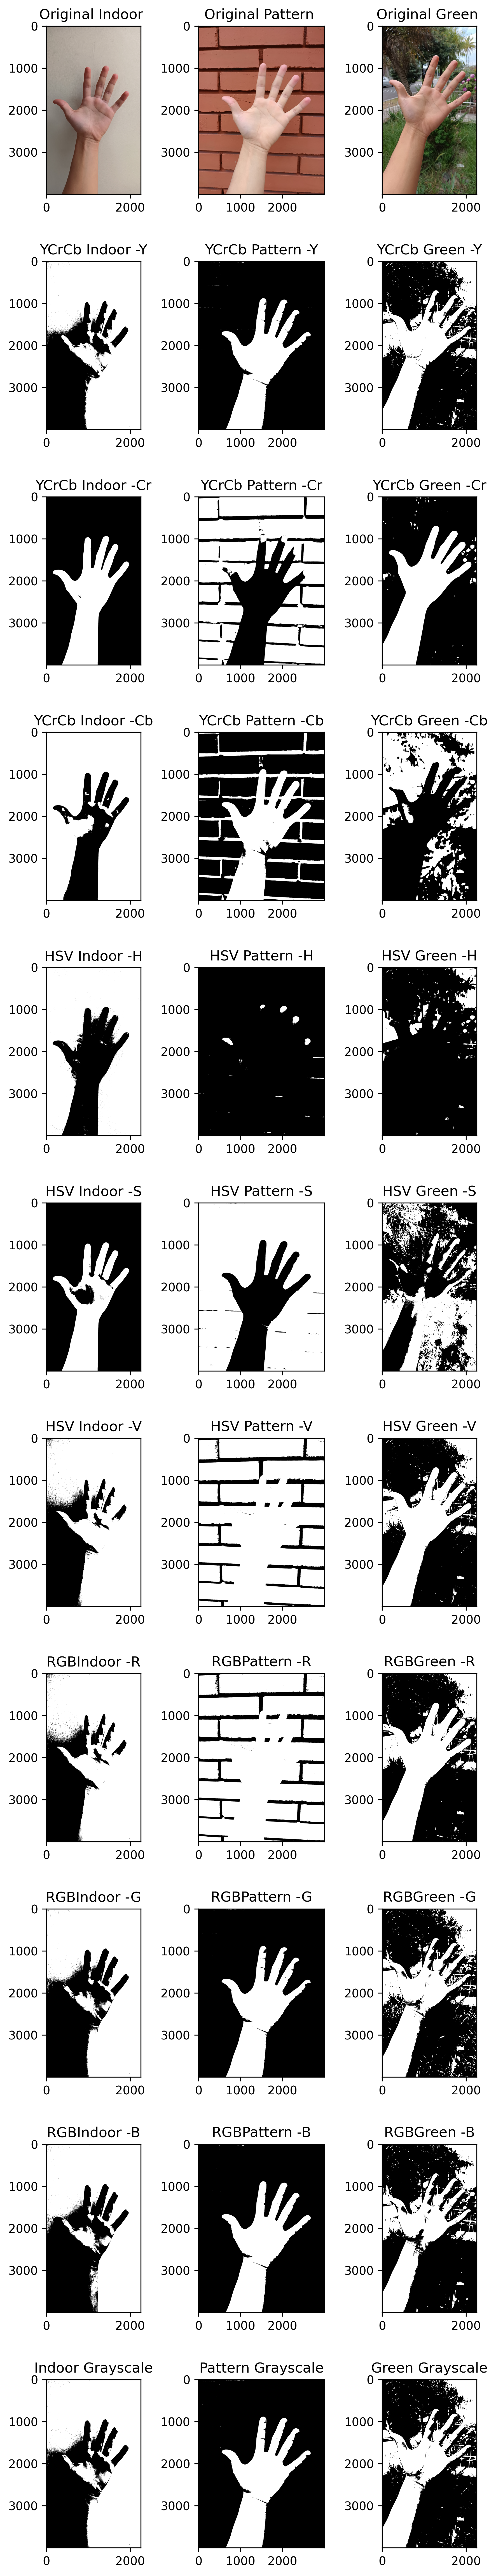

In [107]:

#Espacios de color
Manos_YCrCb = [YCrCb(Indoor_P), YCrCb(Pattern_P), YCrCb(Green_P)]
Manos_HSV = [HSV(Indoor_P), HSV(Pattern_P), HSV(Green_P)] 

#Reducción de bins
bins_0 = 128
Manos_128bins = [lessBins(Indoor_P, bins_0), lessBins(Pattern_P, bins_0), lessBins(Green_P, bins_0)]
bins_1 = 16
Manos_64bins = [lessBins(Indoor_P, bins_1), lessBins(Pattern_P, bins_1), lessBins(Green_P, bins_1)]

res = [Manos_YCrCb, Manos_HSV, Manos_128bins, Manos_64bins]
title1 = ['YCrCb ', 'HSV ', 'RGB', '128 Bins ', '32 Bins ']
title2 = ['Indoor ', 'Pattern ', 'Green ']

title3 = ['-Y', '-Cr', '-Cb','-H','-S','-V','-R','-G','-B']


plt.figure(1)
plt.subplot(11,3,1), plt.imshow(Original_P[0]), plt.title('Original ' + title2[0])
plt.subplot(11,3,2), plt.imshow(Original_P[1]), plt.title('Original ' + title2[1])
plt.subplot(11,3,3), plt.imshow(Original_P[2]), plt.title('Original ' + title2[2])
bins = 256
c = 0
Exec_Time=[]
for i in range(4):
    if i<3:
        for j in range(3):
                for k in range(3):
                    #Se suavisa el histograma para eliminar minimos locales
                    blur = cv2.GaussianBlur(res[i][k], (3,3), 0)
                    img = blur[:,:,j]

                    ref=time.time()
                    tre, otsu = cv2.threshold(img,0,256-1,cv2.THRESH_BINARY + cv2.THRESH_OTSU)
                    Exec_Time.append((time.time()-ref)*1e3)
                    plt.subplot(11,3,c+4), plt.imshow(otsu, cmap=plt.cm.gray), plt.title(title1[i] + title2[k] + title3[j+3*i])
                    c += 1

    else:
        for j in range(3):
                #Se suavisa el histograma para eliminar minimos locales
                blur = cv2.GaussianBlur(res[2][j], (3,3), 0)
                img = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)

                ref=time.time()
                tre, otsu = cv2.threshold(img,0,256-1,cv2.THRESH_BINARY + cv2.THRESH_OTSU)
                Exec_Time.append((time.time()-ref)*1e3)
                plt.subplot(11,3,c+4), plt.imshow(otsu, cmap=plt.cm.gray), plt.title(title2[j] + 'Grayscale')
                c += 1    

                    
            # else:
            #     img = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)

            #     if i == 2:
            #         bins = bins_0
            #     elif i == 3:
            #         bins = bins_1



            
            # #La mano será un máximo global, para garantizar su aparición se usa umbral binario
            # ref=time.time()
            # tre, otsu = cv2.threshold(img,0,bins-1,cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            # Exec_Time.append((time.time()-ref)*1e3)
            # #print(tre)
            # plt.subplot(7,3,c+4), plt.imshow(img, cmap=plt.cm.gray), plt.title(title1[i] + title2[j])
            # c += 1
Exec_Time_mean=sum(Exec_Time) / len(Exec_Time)
print("El tiempo de ejecucion del umbral Otsu es de: "+str(Exec_Time_mean)+"ms")
plt.subplots_adjust(top=2, bottom=0, left=0, right=1, hspace=0.4, wspace=0)

plt.show()

Aunque hay ventajas en los interiores con en el espacio de color HSV y en exteriores con YCrCb con respecto a la reducción en el número de bins, esta última mantiene un balance en todos los casos, evidenciando lo descrito por Michael J. Jones en su estudio en la detección de piel en imágenes.

****Espacios de Color - Rango de color****

Uno de los metodos comunmente utilizados para realizar la segmentacion de la mano consiste en la segmentacion por umbralizacion del espacio de color, para esto se ha de tener en cuenta que para definir los limites de umbral se utilizas el espacio de color HSV de modo que se tiene en cuenta el tono de piel se encuentra cercano para un valor de HUE entre [0,20]. 

El tiempo de ejecucion del umbral Otsu es de: 15.37926991780599ms


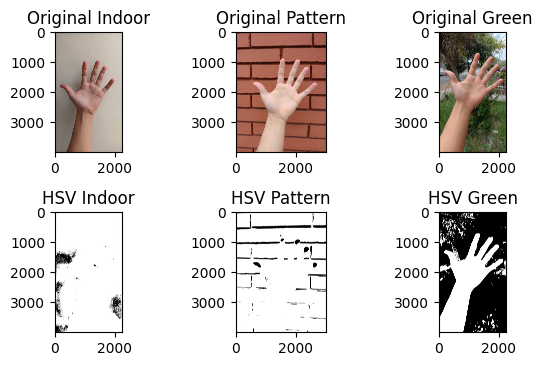

In [4]:

title1 = 'HSV '
title2 = ['Indoor', 'Pattern', 'Green']

plt.figure(1)
plt.subplot(7,3,1), plt.imshow(Original_P[0]), plt.title('Original ' + title2[0])
plt.subplot(7,3,2), plt.imshow(Original_P[1]), plt.title('Original ' + title2[1])
plt.subplot(7,3,3), plt.imshow(Original_P[2]), plt.title('Original ' + title2[2])
bins = 256
c = 0
lower_skin = np.array([0,20,70], dtype=np.uint8)
upper_skin = np.array([20,255,255], dtype=np.uint8)
Exec_Time=[]

for j in range(3):

    #Se suavisa el histograma para eliminar minimos locales
    blur = cv2.GaussianBlur(Manos_HSV[j], (3,3), 0)

    #La mano será un máximo global, para garantizar su aparición se usa umbral binario
    ref=time.time()
    mask = cv2.inRange(blur, lower_skin, upper_skin)
    Exec_Time.append((time.time()-ref)*1e3)

    #print(tre)
    plt.subplot(7,3,c+4), plt.imshow(mask, cmap=plt.cm.gray), plt.title(title1 + title2[j])
    c += 1

Exec_Time_mean=sum(Exec_Time) / len(Exec_Time)
print("El tiempo de ejecucion del umbral Otsu es de: "+str(Exec_Time_mean)+"ms")
plt.subplots_adjust(top=3, bottom=0.5, left=0.0, right=0.8, hspace=0.5, wspace=0.5)
plt.show()

Como se puede observar en el entorno de exteriores el umbral de la mano esta bien definido, mas sin embargo cuando el entorno entra dentro del umbral de color definido, no se realiza una umbralizacion correctamente, por ende de manera general no es un buen resultado a diferencia de la umbralizacion de otsu realizado en diferentes espacios de color.

****Super Pixeles - SLIC****

Otro metodo que se plantea para realizar la semgnentacion corresponde a la generacion de clusteres aleatorios que agrupen caracteristicas similares de pixeles vecinos, esto con la finalidad de agrupar los pixeles que conforman la mano cuyas caracteristicas son muy similares entre si.

In [5]:
from skimage import graph, color, filters, morphology, segmentation, measure, feature
from scipy import ndimage as ndi

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

def _weight_mean_color(graph, src, dst, n):
    """Callback to handle merging nodes by recomputing mean color.

    The method expects that the mean color of `dst` is already computed.

    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    n : int
        A neighbor of `src` or `dst` or both.

    Returns
    -------
    data : dict
        A dictionary with the `"weight"` attribute set as the absolute
        difference of the mean color between node `dst` and `n`.
    """

    diff = graph.nodes[dst]['mean color'] - graph.nodes[n]['mean color']
    diff = np.linalg.norm(diff)
    return {'weight': diff}

def merge_mean_color(graph, src, dst):
    """Callback called before merging two nodes of a mean color distance graph.

    This method computes the mean color of `dst`.

    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    """
    graph.nodes[dst]['total color'] += graph.nodes[src]['total color']
    graph.nodes[dst]['pixel count'] += graph.nodes[src]['pixel count']
    graph.nodes[dst]['mean color'] = (
        graph.nodes[dst]['total color'] / graph.nodes[dst]['pixel count']
    )

title0 = 'SP'
title1 = [' Orig', ' YCrCb ', ' HSV ']
title2 = [' Indoor', ' Pattern', ' Green']
res = [Original_P, Manos_YCrCb, Manos_HSV]
plt.figure(1)
plt.subplot(7,3,1), plt.imshow(Original_P[0]), plt.title('Original ' + title2[0])
plt.subplot(7,3,2), plt.imshow(Original_P[1]), plt.title('Original ' + title2[1])
plt.subplot(7,3,3), plt.imshow(Original_P[2]), plt.title('Original ' + title2[2])
bins = 256
c = 0
Exec_Time=[]
for i in range(3):
        for j in range(3):

                #Se suavisa el histograma para eliminar minimos locales
                ref=time.time()
                blur = cv2.GaussianBlur(res[i][j], (3,3), 0)

                Segment=segmentation.slic(blur, n_segments=300)

                out = segmentation.mark_boundaries(blur, Segment, (0, 0, 0))

                Exec_Time.append((time.time()-ref)*1e3)
                plt.subplot(7,3,4+c), plt.imshow(out), plt.title(title0 + title1[i] + title2[j])
                c += 1

Exec_Time_mean=sum(Exec_Time) / len(Exec_Time)
print("El tiempo de ejecucion de superpixeles es de: "+str(Exec_Time_mean)+"ms")
plt.subplots_adjust(top=3, bottom=0.5, left=0.0, right=0.8, hspace=0.5, wspace=0.5)
plt.show()


El tiempo de ejecucion de superpixeles es de: 13967.281685935126ms


A traves del algoritmo SLIC se puede observar como este presenta una mejor integracion con el espacio de color RGB original, por ende se implementara unicamente este espacio de color para utilizar los superpixeles, adicionalmente se observa que el tiempo de ejecucion del algoritmo SLIC es mucho mayor que los filtros comunes debido a la agrupacion de pixeles en clusters. Por ende para una implementacion sencilla y que no consuma recursos se opto por utilizar umbralizacion de Otsu en el espacio de color HSV.

80.456203
129.10306944444446
90.61313588888889
El tiempo de ejecucion del umbral Otsu es de: 44.59524154663086ms


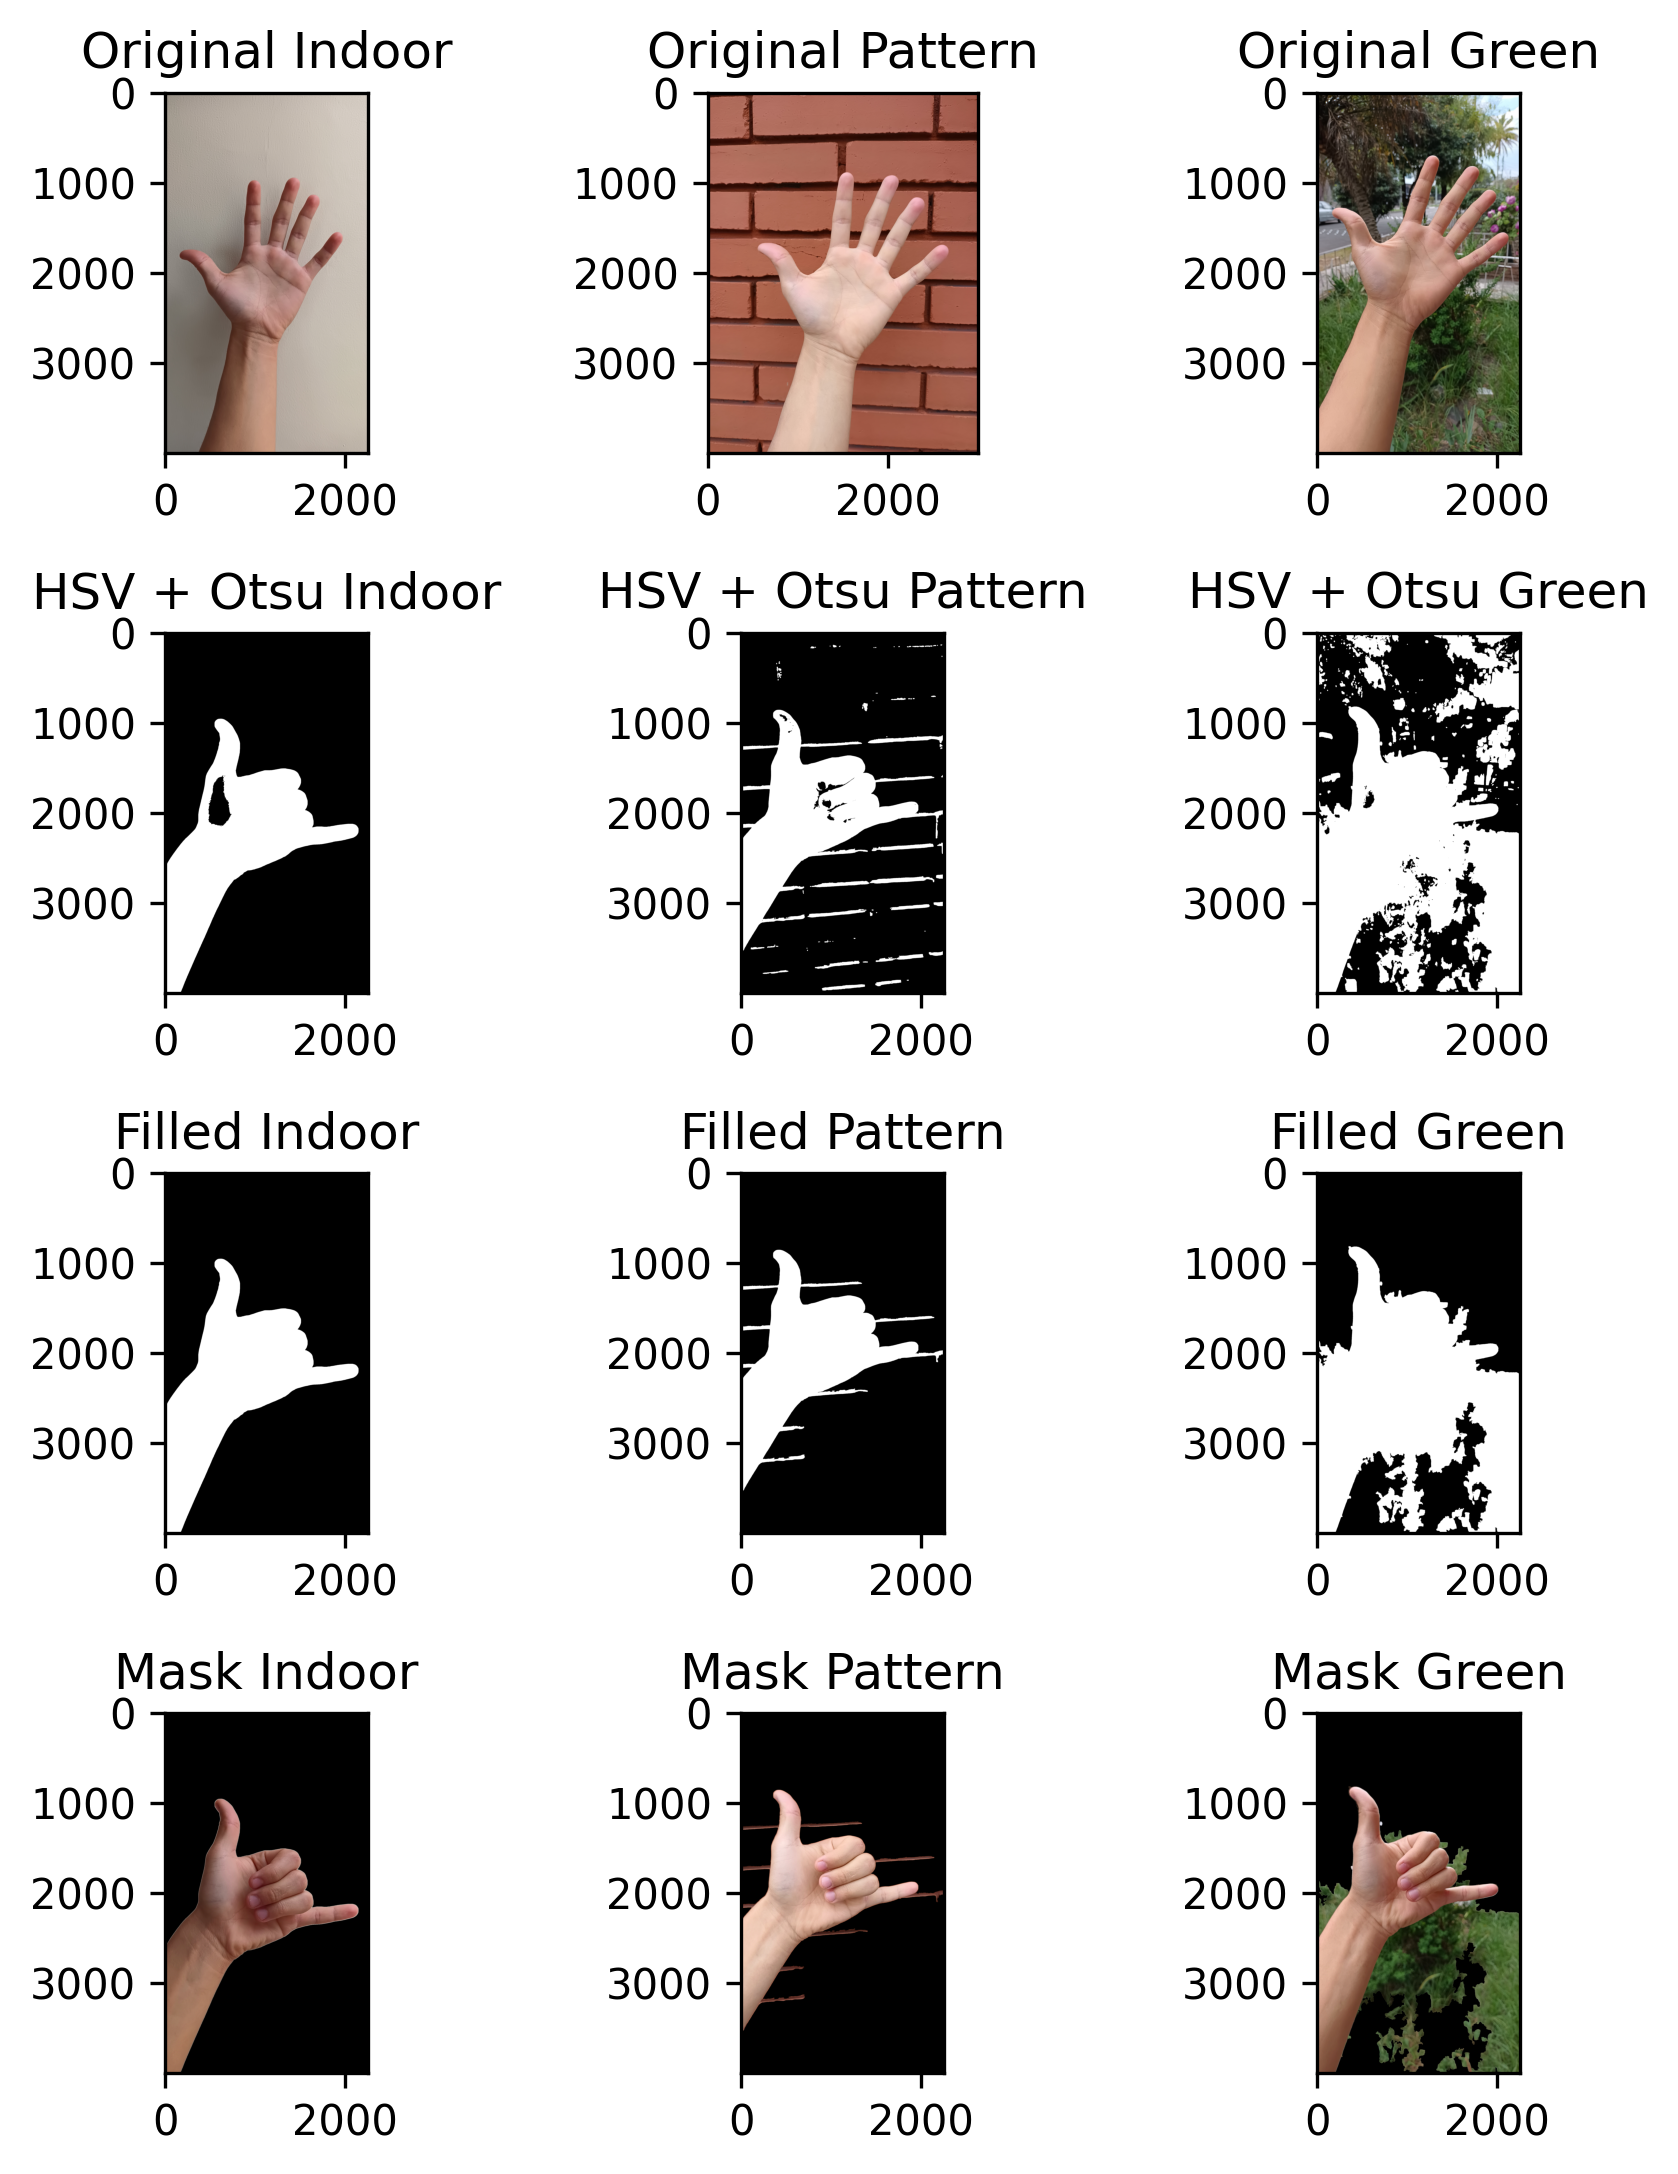

In [6]:
#Espacios de color
Manos_HSV = [HSV(Indoor_G), HSV(Pattern_G), HSV(Green_G)] 

#Reducción de bins

title2 = ['Indoor', 'Pattern', 'Green']

plt.figure(1)
plt.subplot(7,3,1), plt.imshow(Original_P[0]), plt.title('Original ' + title2[0])
plt.subplot(7,3,2), plt.imshow(Original_P[1]), plt.title('Original ' + title2[1])
plt.subplot(7,3,3), plt.imshow(Original_P[2]), plt.title('Original ' + title2[2])

c = 0
Exec_Time=[]

for j in range(3):

        #Se suavisa el histograma para eliminar minimos locales
        blur = cv2.GaussianBlur(Manos_HSV[j], (3,3), 0)
        img = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)

        #Calculo del brillo de la imagen
        x,y=img.shape[:2]
        brillo=np.sum(img)/(x*y)
        print(brillo)

        #La mano será un máximo global, para garantizar su aparición se usa umbral binario
        ref=time.time()
        tre, otsu = cv2.threshold(img,0,256-1,cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        #Inversion del umbral en dado caso que el brillo de la imagen sea mayor a 110
        if(brillo>110):
                otsu=~otsu

        kernel = np.ones((5, 5), np.uint8)
        otsu=cv2.dilate(otsu, kernel, iterations = 2)

        #Hallar contorno de la imagen umbralizada
        contours = cv2.findContours(otsu, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours = contours[0] if len(contours) == 2 else contours[1]
        big_contour = max(contours, key=cv2.contourArea)

        #Rellenar el contorno de la imagen umbralizada.
        result = np.zeros_like(img)
        cv2.drawContours(result, [big_contour], 0, (255,255,255), cv2.FILLED)

        masked =  cv2.cvtColor(cv2.bitwise_and(Manos_HSV[j], Manos_HSV[j], mask=result), cv2.COLOR_HSV2RGB)

        Exec_Time.append((time.time()-ref)*1e3)
        plt.subplot(7,3,c+4), plt.imshow(otsu, cmap=plt.cm.gray), plt.title('HSV + Otsu ' + title2[j])
        plt.subplot(7,3,c+7), plt.imshow(result, cmap=plt.cm.gray), plt.title('Filled ' + title2[j])
        plt.subplot(7,3,c+10), plt.imshow(masked, cmap=plt.cm.gray), plt.title('Mask ' + title2[j])

        c += 1
Exec_Time_mean=sum(Exec_Time) / len(Exec_Time)
print("El tiempo de ejecucion del umbral Otsu es de: "+str(Exec_Time_mean)+"ms")
plt.subplots_adjust(top=3, bottom=0.5, left=0.0, right=0.8, hspace=0.5, wspace=0.5)
plt.show()

***Extraccion de caracteristicas***

****Finger Extraction Algorithm Based on Parallel edge Feature****

Este metodo de extraccion de caracteristicas se basa en el articulo titulado "A novel finger and hand pose estimation technique for real-time hand gesture recognition" del año 2015, para ello se implementa el siguiente algoritmo.

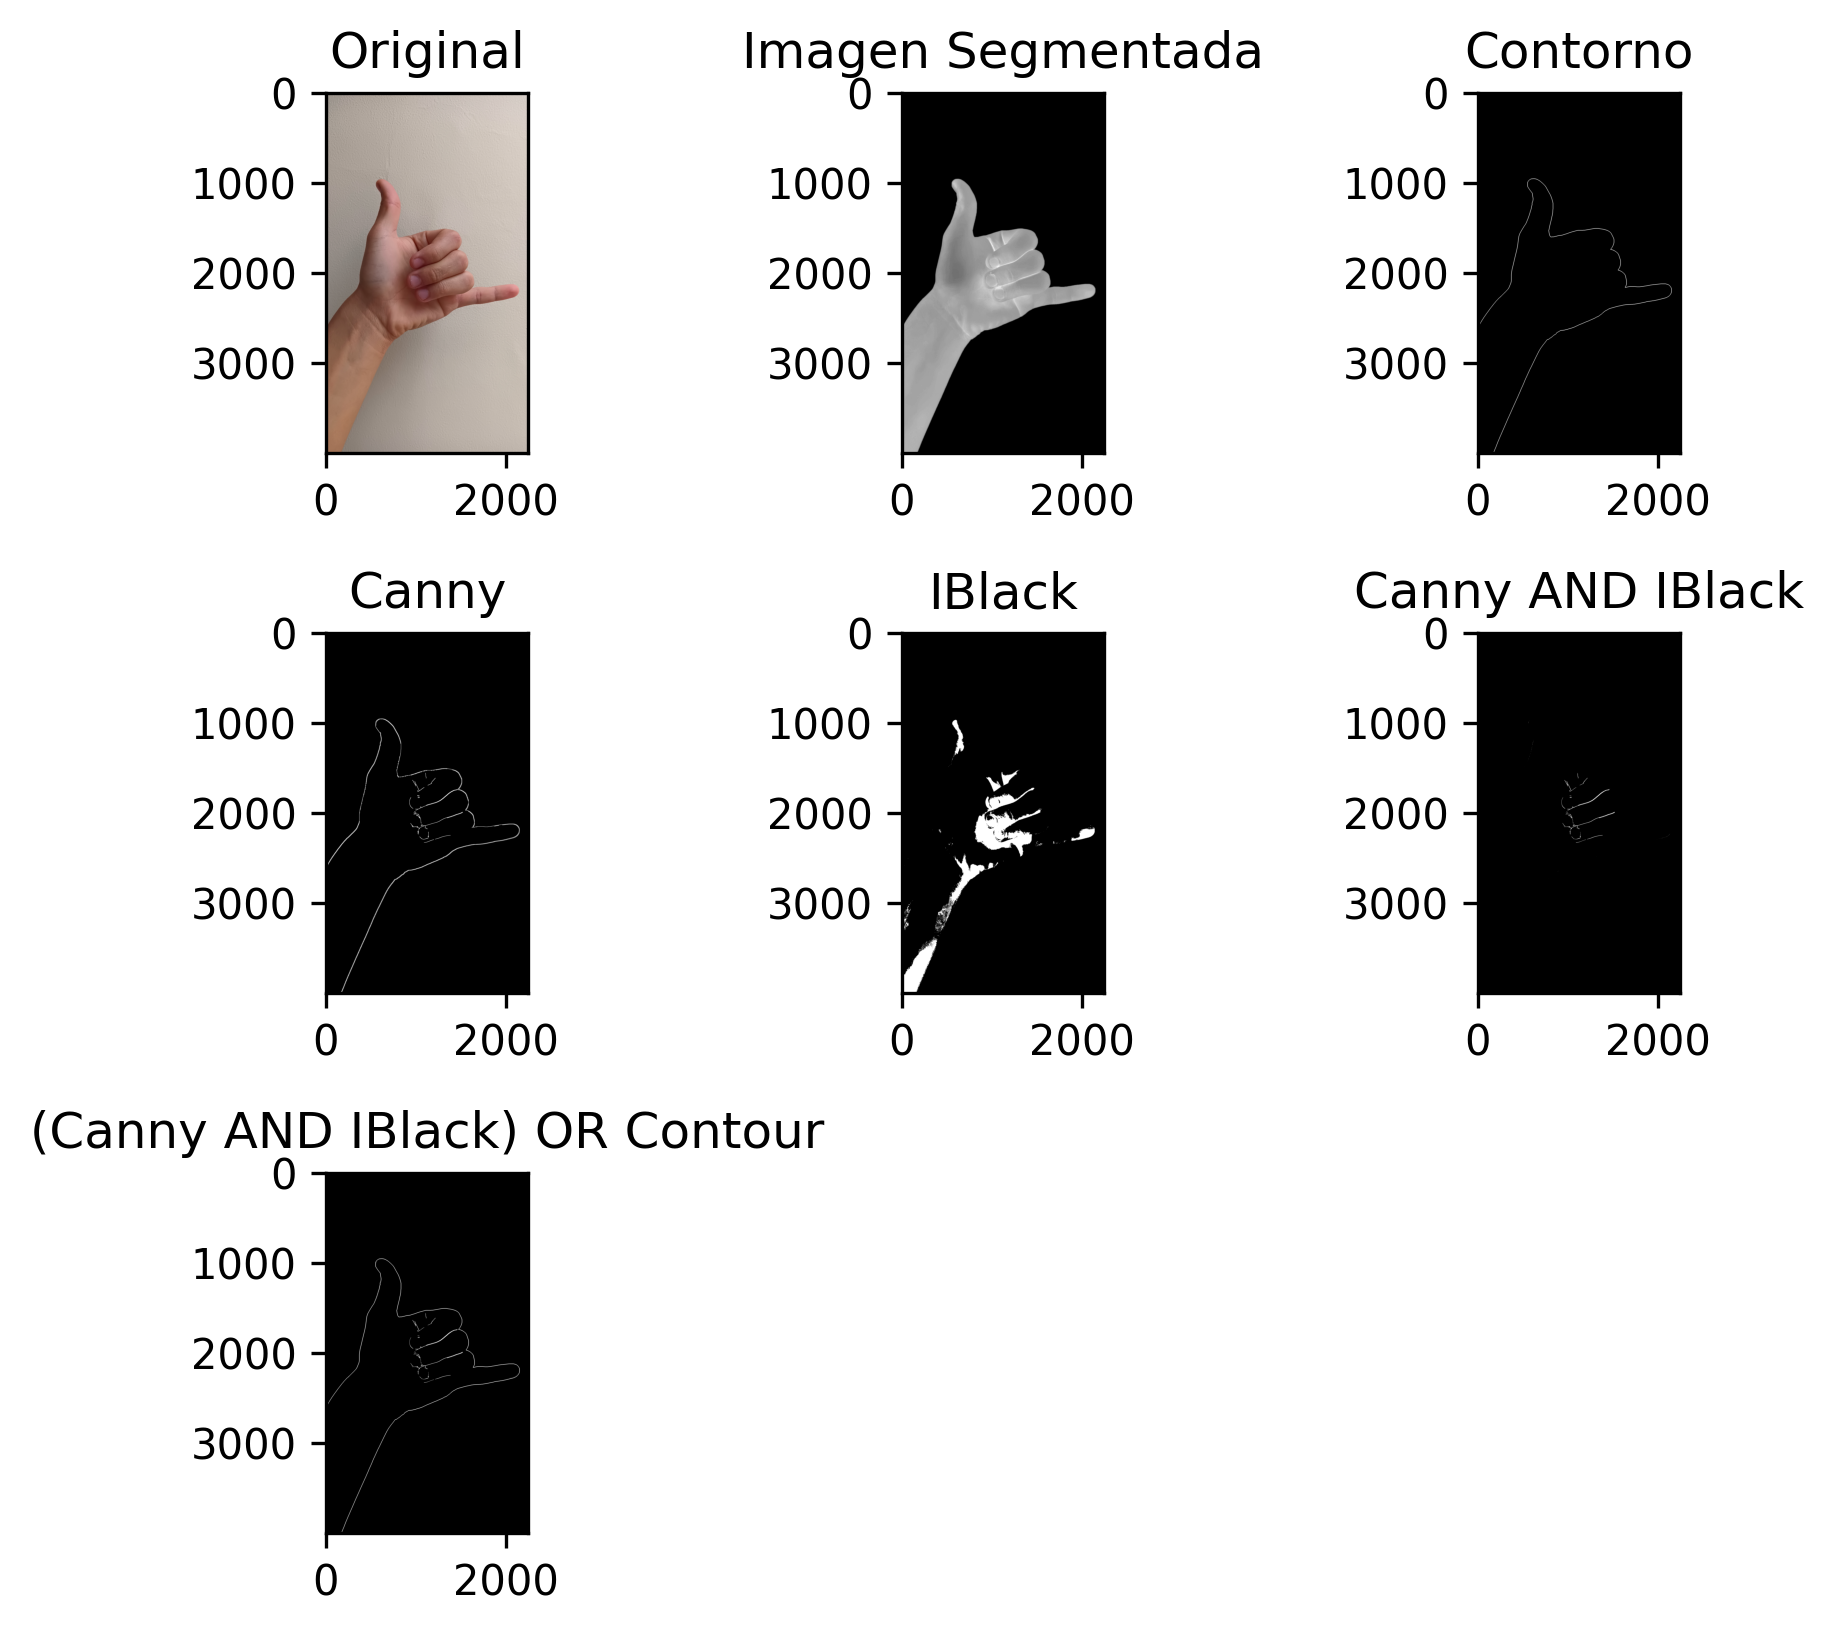

In [10]:
from skimage import feature, filters
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

ref=time.time()

#### Proceso de segmentacion de la imagen ####
Imagen=Indoor_G

#Se suavisa el histograma para eliminar minimos locales
blur = cv2.GaussianBlur(HSV(Imagen), (3,3), 0)
img = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)

#Calculo del brillo de la imagen
x,y=img.shape[:2]
brillo=np.sum(img)/(x*y)

#La mano será un máximo global, para garantizar su aparición se usa umbral binario
tre, otsu = cv2.threshold(img,0,256-1,cv2.THRESH_BINARY + cv2.THRESH_OTSU)

#Inversion del umbral en dado caso que el brillo de la imagen sea mayor a 110
if(brillo>110):
        otsu=~otsu

kernel = np.ones((5, 5), np.uint8)
otsu=cv2.dilate(otsu, kernel, iterations = 2)


#Hallar contorno de la imagen umbralizada
contours = cv2.findContours(otsu, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]
big_contour = max(contours, key=cv2.contourArea)

#Rellenar el contorno de la imagen umbralizada.
result = np.zeros_like(img)
cv2.drawContours(result, [big_contour], 0, (255,255,255), cv2.FILLED)

#Segmentacion de la imagen
masked =  cv2.bitwise_and(img, img, mask=result)

plt.figure(1)
plt.subplot(7,3,1), plt.imshow(Imagen), plt.title('Original')
plt.subplot(7,3,2), plt.imshow(masked ,cmap=plt.cm.gray), plt.title('Imagen Segmentada')

#### Extraccion de caracteristicas ####
kernel = np.ones((3, 3), np.uint8)


#Contorno
Contour = np.zeros_like(img)
cv2.drawContours(Contour, [big_contour], 0, (255,255,255),3)
#Contour=cv2.dilate(Contour, kernel, iterations = 1)
plt.subplot(7,3,3), plt.imshow(Contour ,cmap=plt.cm.gray), plt.title('Contorno')

#Filtro Canny
Edge = feature.canny(masked,sigma=1).astype(np.uint8)
Edge=cv2.dilate(Edge, kernel, iterations = 1)
plt.subplot(7,3,4), plt.imshow(Edge ,cmap=plt.cm.gray), plt.title('Canny')

#Threshold THblack
_,shadows = cv2.threshold(masked,115,255,cv2.THRESH_BINARY)
plt.subplot(7,3,5), plt.imshow(shadows ,cmap=plt.cm.gray), plt.title('IBlack')

#AND - THblack, Canny
AND_operation=cv2.bitwise_and(shadows,Edge)*255
#AND_operation=cv2.dilate(AND_operation, kernel, iterations = 1)
plt.subplot(7,3,6), plt.imshow(AND_operation ,cmap=plt.cm.gray), plt.title('Canny AND IBlack')

#OR - AND, Contour
Final = cv2.bitwise_or(Contour, AND_operation)
#Final=cv2.dilate(Final, kernel, iterations = 1)
plt.subplot(7,3,7), plt.imshow(Final ,cmap=plt.cm.gray), plt.title('(Canny AND IBlack) OR Contour')

plt.subplots_adjust(top=3, bottom=0.5, left=0.0, right=0.8, hspace=0.5, wspace=0.5)
plt.show()

Como se puede observar a traves de diferentes filtros de borde es posible obtener la silueta de la mano con alguna informacion de los dedos, por ende ahora se busca obtener informacion de estos mismos.

Con la silueta completa de la mano, lo siguiente es hallar la estructura de los dedos, en otras palabras identificar los dedos. Esto mediante una mascara que me elimina los contornos y dibuja en sus extremos.

El tiempo de ejecucion de Filter2D es de: 0.3553178310394287
El tiempo de ejecucion de Convolve2D es de: 989.4689326286316


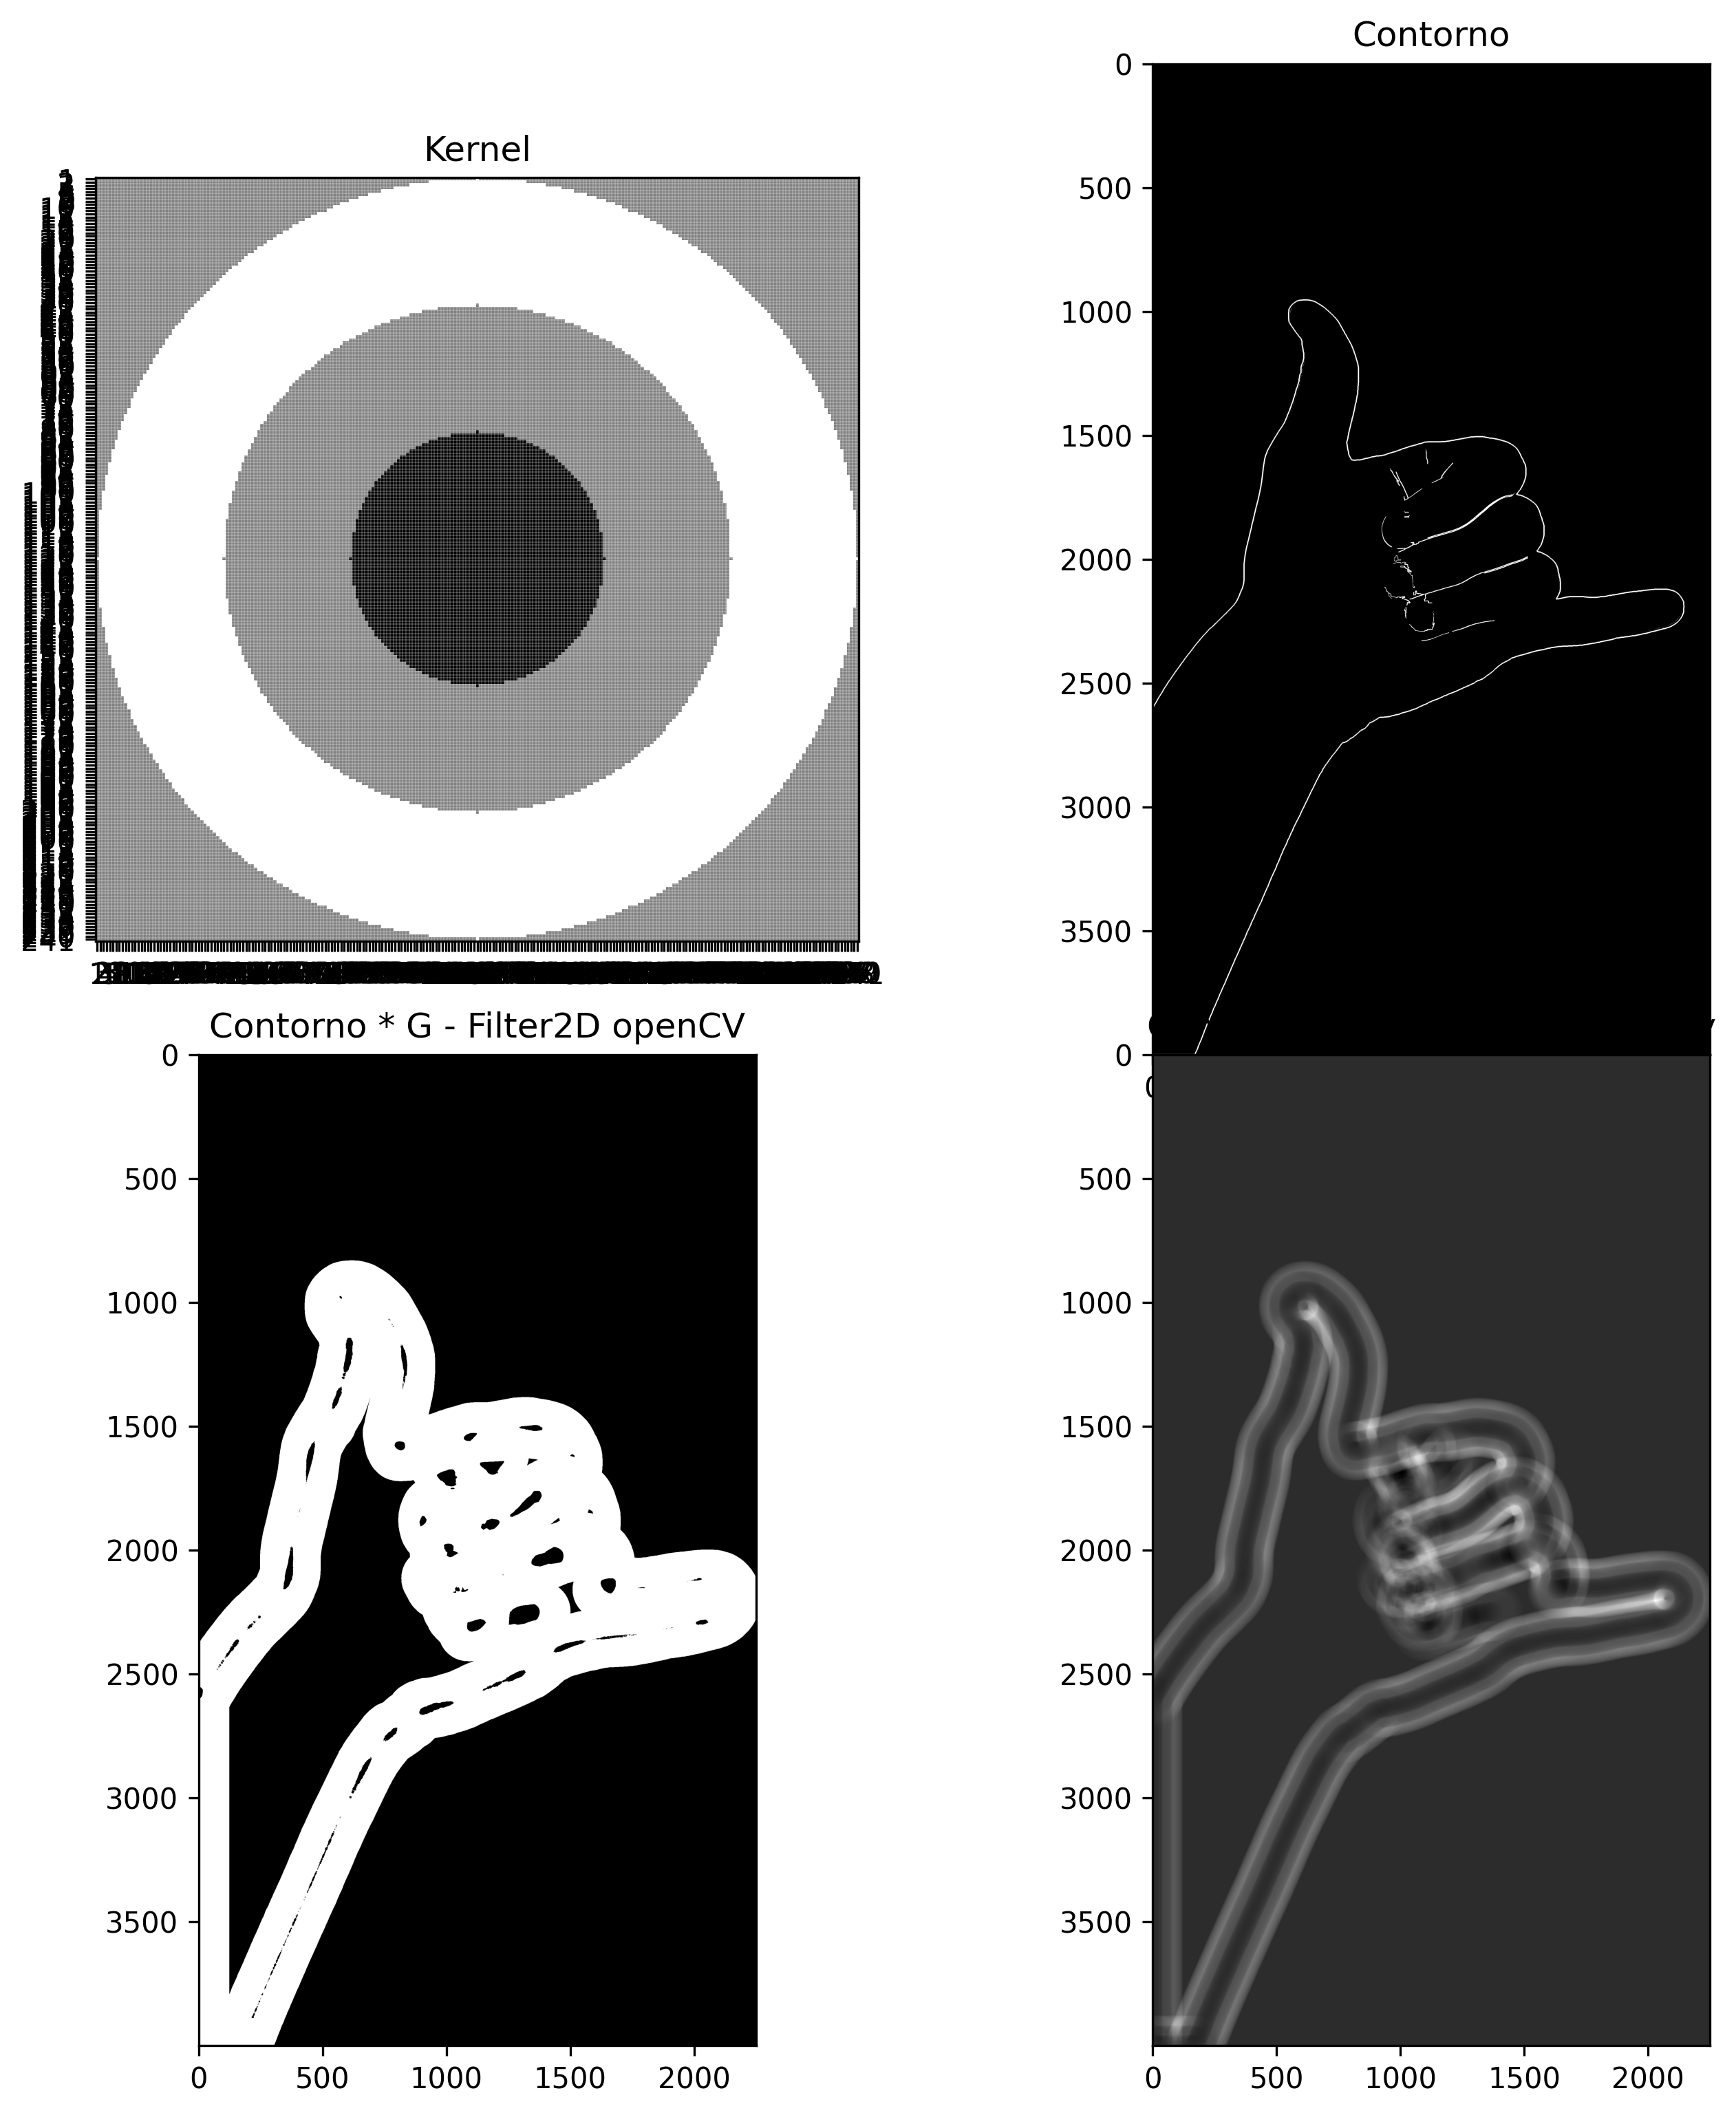

In [37]:
from scipy import signal
from scipy import ndimage


#Máscara de 7x7 hay que se expande N veces, donde N es una cuarta parte del grosor del dedo
def generator(N):

    d = 1+ 3*2*N
    matriz = np.zeros((d,d))
    matriz1 = np.zeros((d,d))
    matriz2 = np.zeros((d,d))


    center = 3*N
    matriz[center][center] = -1
    matriz1[center][center] = 1

    for i in range(d):
         for j in range(d):
            
            radio = np.sqrt((i - center)**2 + (j - center)**2)
            if radio <= N:
                matriz[i, j] = -1
                matriz1[i, j] = 1

            elif radio <= 3*N and radio > 2*N:
                matriz[i, j] = 1
                matriz2[i, j] = 1

    return matriz,matriz1,matriz2

#### Creacion del kernel con G ####
N=40
d=int(1+ 3*2*N)
G,G_1,G_2 = np.array(generator(N))
plt.figure(1)
plt.subplot(2,2,1), plt.imshow(np.flip(G), cmap=plt.cm.gray), plt.title('Kernel')
ax = plt.gca()

# Major ticks
ax.set_xticks(np.arange(0, N*3*2+1, 1))
ax.set_yticks(np.arange(0, N*3*2+1, 1))

# Labels for major ticks
ax.set_xticklabels(np.arange(1, N*3*2+2, 1))
ax.set_yticklabels(np.arange(1, N*3*2+2, 1))

# Minor ticks
ax.set_xticks(np.arange(-.5, N*3*2+1, 1), minor=True)
ax.set_yticks(np.arange(-.5, N*3*2+1, 1), minor=True)

# Gridlines based on minor ticks
ax.grid(which='minor', color='w', linestyle='-', linewidth=0.1)

# Remove minor ticks
ax.tick_params(which='minor', bottom=False, left=False)


#### Identificacion de los dedos ####
ref=time.time()
Convolution_Result = cv2.filter2D(Final, -1, np.flip(G))
opencvtime=time.time()-ref
ref=time.time()
Convolution_Result2 = signal.convolve2d(Final,G,mode='same')
Scipytime=time.time()-ref

print('El tiempo de ejecucion de Filter2D es de: '+str(opencvtime))
print('El tiempo de ejecucion de Convolve2D es de: '+str(Scipytime))

# Dilate_1 = cv2.dilate(Final, G_1.astype(np.uint8))
# Dilate_2 = cv2.dilate(Final, G_2.astype(np.uint8))
# result=cv2.bitwise_and(cv2.bitwise_not(Dilate_1),Dilate_2)

plt.subplot(2,2,2), plt.imshow(Final, cmap=plt.cm.gray), plt.title('Contorno')
plt.subplot(2,2,3), plt.imshow(Convolution_Result, cmap=plt.cm.gray), plt.title('Contorno * G - Filter2D openCV')
plt.subplot(2,2,4), plt.imshow(Convolution_Result2, cmap=plt.cm.gray), plt.title('Contorno * G - Convolve2D Scipy')

plt.subplots_adjust(top=2, bottom=0.0, left=0.0, right=1.3, hspace=0, wspace=0.25)
plt.show()

Como se puede observar, al realizar la convolucion de la imagen por el kernel invariante al a rotacion, el resultado obtenido por Filter2D no es muy valido ni parecido a lo presentado en el paper, ademas de que su tiempo de ejecucion es de 0.43s, mientras que el resultado obtenido por Convolve2D es similar al resultado mas sin embargo su tiempo de ejecucion es de 15m, haciendolo inviable.

****Real-Time Hand Gesture Recognition Using Finger Segmentation****

A raiz del problema expuesto anteriormente se planteo implementar un metodo en base al articulo "Real-Time Hand Gesture Recognition Using Finger Segmentation", partiendo desde la imagen segmentada. Lo primero que se busca implementar consiste en la transformada de distancia o mapa de distancia con el fin de identificar la palma de la mano, de modo que se desarrollo el siguiente codigo.


[  3.           0.          29.54954955 116.03603604   0.
   0.           0.35722515   0.30288399   0.54518118   0.
   0.           1.4          0.9          1.4          0.
   0.           0.61880245   0.89736814   0.78795696   0.
   0.        ]


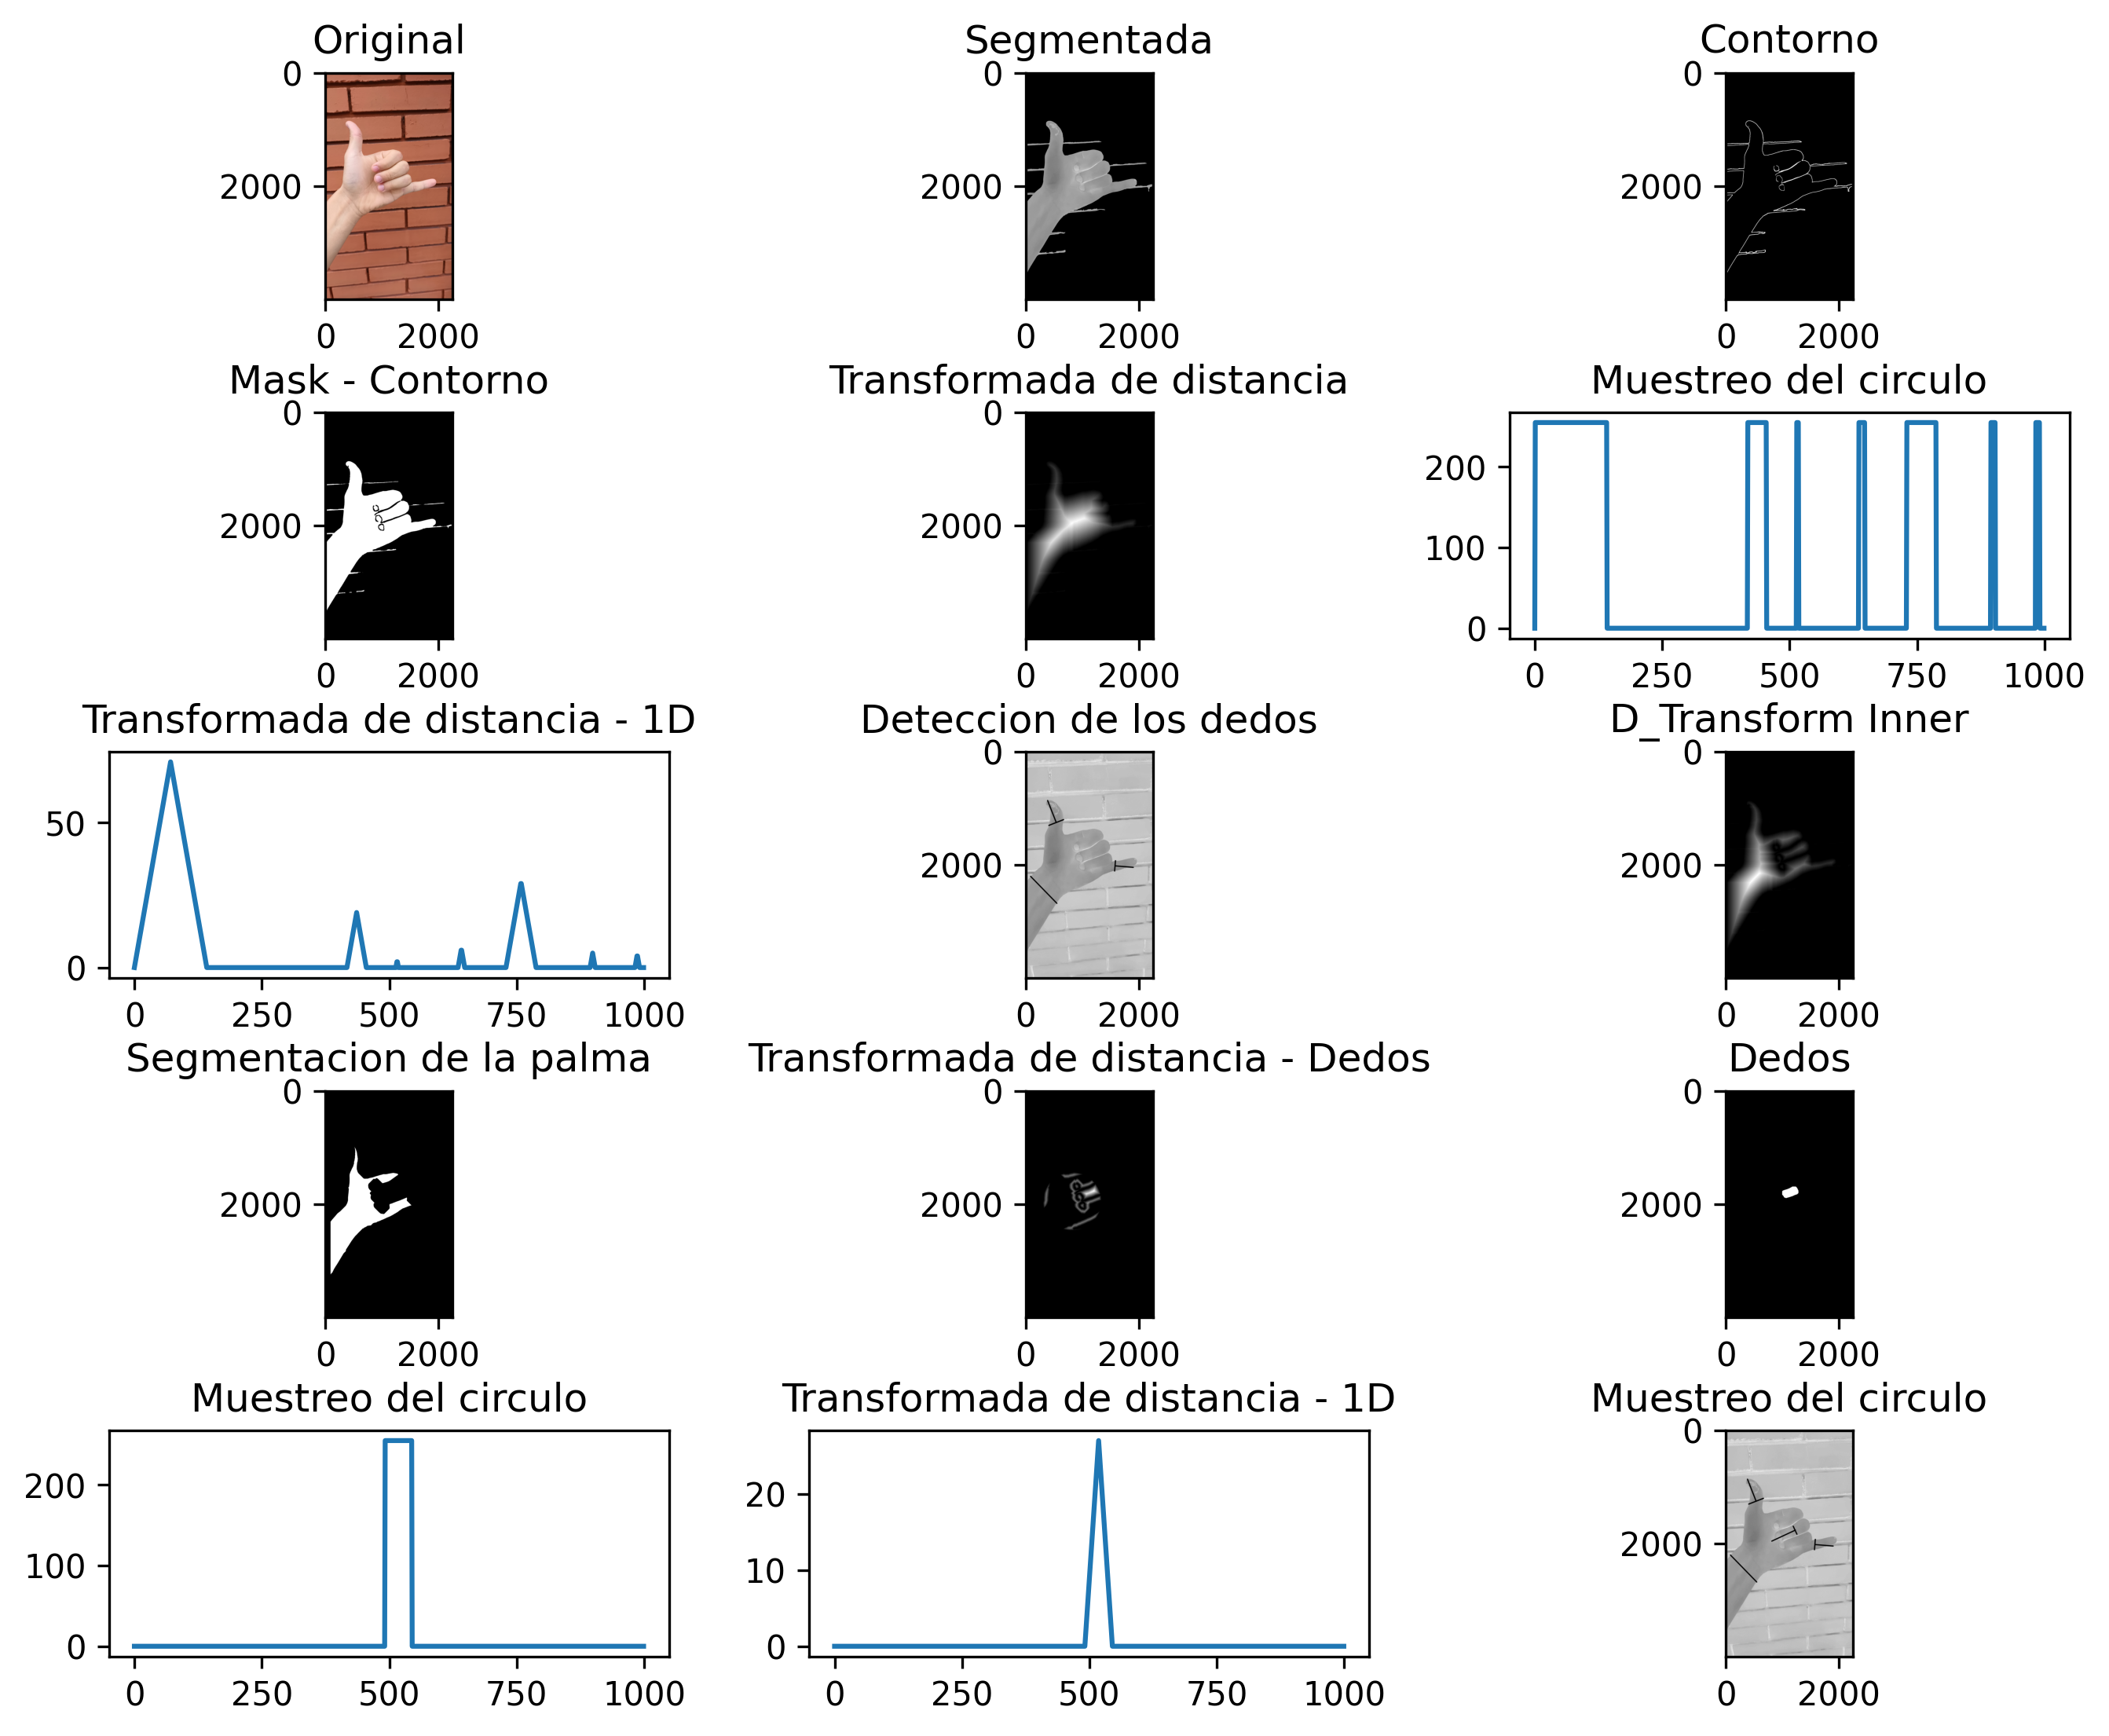

In [38]:
from skimage import feature, filters
from scipy import signal
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300


############################### Proceso de segmentacion de la imagen ###############################
Imagen=Pattern_G

#Referencia del tiempo de ejecucion
ref=time.time()

#Se suavisa el histograma para eliminar minimos locales
blur = cv2.GaussianBlur(HSV(Imagen), (3,3), 0)
img = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)

#Calculo del brillo de la imagen
y,x=img.shape[:2]
brillo=np.sum(img)/(x*y)

#La mano será un máximo global, para garantizar su aparición se usa umbral binario
tre, otsu = cv2.threshold(img,0,255,cv2.THRESH_BINARY + cv2.THRESH_OTSU)

#Inversion del umbral en dado caso que el brillo de la imagen sea mayor a 110
if(brillo>110):
        otsu=~otsu

#Dilatar el umbral Otsu para rellenar Huecos
kernel = np.ones((5, 5), np.uint8)
otsu=cv2.dilate(otsu, kernel, iterations = 2)

#Hallar los contornos de la imagen
c_Var = cv2.findContours(otsu, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
c_Var = c_Var[0] if len(c_Var) == 2 else c_Var[1]
C_var = max(c_Var, key=cv2.contourArea)

#Obtener el contorno y su version rellena sin borde
Contorno_Fill   = np.zeros_like(img)
Contorno        = np.zeros_like(img)
cv2.drawContours(Contorno_Fill, [C_var], 0, (255,255,255), cv2.FILLED)
cv2.drawContours(Contorno, [C_var], 0, (255,255,255), 3)
Contorno_Fill=cv2.bitwise_and(cv2.bitwise_not(Contorno),Contorno_Fill)

#Segmentacion de la imagen
Image_Masked =  cv2.bitwise_and(img, Contorno_Fill)

plt.figure(1)
plt.subplot(7,3,1), plt.imshow(Imagen), plt.title('Original')
plt.subplot(7,3,2), plt.imshow(Image_Masked ,cmap=plt.cm.gray), plt.title('Segmentada')



############################### Extraccion de caracteristicas ###############################

#Filtro Canny
Edge = feature.canny(Image_Masked,sigma=1).astype(np.uint8)
Edge = cv2.dilate(Edge, kernel, iterations = 2)

#Threshold THblack
_,shadows = cv2.threshold(Image_Masked,115,255,cv2.THRESH_BINARY)

#AND - THblack, Canny
AND_operation=cv2.bitwise_and(shadows,Edge)*255

#OR - AND, Contour
Contorno_Detail = cv2.bitwise_or(Contorno, AND_operation)
plt.subplot(7,3,3), plt.imshow(Contorno_Detail ,cmap=plt.cm.gray), plt.title('Contorno')

#Mascara sin los detalles del contorno
Contorno_Fill_Edge=cv2.bitwise_and(cv2.bitwise_not(Contorno_Detail),Contorno_Fill)
Contorno_Fill_Edge = cv2.erode(Contorno_Fill_Edge, kernel, iterations = 2)
plt.subplot(7,3,4), plt.imshow(Contorno_Fill_Edge ,cmap=plt.cm.gray), plt.title('Mask - Contorno')

#Calculo de la transformada de distancia, radio y coordenadas para generar el circulo de la palma
D_Transform=cv2.distanceTransform(Contorno_Fill, distanceType=cv2.DIST_L1, maskSize=3)
R_DT_1=np.max(D_Transform)
Coor_DT_1=(np.argmax(D_Transform)%x,np.argmax(D_Transform)//x)
plt.subplot(7,3,5), plt.imshow(D_Transform ,cmap=plt.cm.gray), plt.title('Transformada de distancia')

#Circulos de la palma
Circle=cv2.circle(np.zeros_like(img), Coor_DT_1, int(R_DT_1), 255, -1) 
Circle_max=cv2.circle(np.zeros_like(img), Coor_DT_1, int(R_DT_1*1.5), 255, -1) 

#Crear un muestreo de n puntos con el circulo mascara respecto la imagen original, lo cual dara indicios de en que lugar se encuentra la palma y los dedos
Angle=np.linspace(0,360,1000)
Radial_Sample=np.zeros_like(Angle)
Index_y=np.clip((int(R_DT_1*1.5)*np.cos(Angle*np.pi/180)+Coor_DT_1[1]).astype(int),0,y-1)
Index_x=np.clip((int(R_DT_1*1.5)*np.sin(Angle*np.pi/180)+Coor_DT_1[0]).astype(int),0,x-1)
for i in range(0,len(Radial_Sample)):
        Radial_Sample[i]=Contorno_Fill[Index_y[i]][Index_x[i]]

#Ajuste para comenzar el arreglo en el primer punto minimo
Shift=np.argmin(Radial_Sample)
Radial_Sample=np.roll(Radial_Sample,-Shift)
Radial_Sample[-1]=0

#Realizar la transformada de distancia para identificar el punto central de los dedos y palma, ademas de su anchura
D_Transform_Samples=cv2.distanceTransform(Radial_Sample.astype(np.uint8), distanceType=cv2.DIST_L1, maskSize=3)
D_T_Samples_R=np.max(D_Transform_Samples).astype(int)
D_T_Samples_C=np.argmax(D_Transform_Samples).astype(int)

#Ajustar los arreglos para que siempre empiecen con el punto maximo, correspondiente a la palma
Radial_Sample=np.roll(Radial_Sample,D_T_Samples_R+len(Angle)-D_T_Samples_C)
Index_y=np.roll(Index_y,D_T_Samples_R+len(Angle)-D_T_Samples_C-Shift)
Index_x=np.roll(Index_x,D_T_Samples_R+len(Angle)-D_T_Samples_C-Shift)
D_Transform_Samples=np.roll(D_Transform_Samples,D_T_Samples_R+len(Angle)-D_T_Samples_C)
D_Transform_Samples=D_Transform_Samples.flatten()
Angle=np.roll(Angle,D_T_Samples_R+len(Angle)-D_T_Samples_C-Shift)
plt.subplot(7,3,6), plt.plot(Radial_Sample), plt.title('Muestreo del circulo')
plt.subplot(7,3,7), plt.plot(D_Transform_Samples), plt.title('Transformada de distancia - 1D')

#Encontrar el indice del circulo en el que se encuentran los dedos y la palma, tambien su radio
Peak_Center=signal.find_peaks(D_Transform_Samples, height=10, width=5)
Peak_Center=Peak_Center[0].astype(int)
if(len(Peak_Center)>6):
        Peak_Center=Peak_Center[:6]
Peak_Radius=D_Transform_Samples[Peak_Center].astype(int)

#Puntos centra, y extremos de los dedos
Point_1=np.vstack((Index_x[Peak_Center-Peak_Radius], Index_y[Peak_Center-Peak_Radius])).T
Point_2=np.vstack((Index_x[Peak_Center+Peak_Radius], Index_y[Peak_Center+Peak_Radius])).T
Point_Center=np.vstack((Index_x[Peak_Center], Index_y[Peak_Center])).T
Angle_Points=Angle[Peak_Center]

FingerSize_1=np.zeros_like(Peak_Center).astype(float)
FingerSize_Inner_1=np.zeros_like(Peak_Center).astype(float)
#Lineas de los dedos y palma
for i in range(0,len(Peak_Center)):
        FingerSize_1[i]=np.sqrt((Point_1[i][0]-Point_2[i][0])**2+(Point_1[i][1]-Point_2[i][1])**2)/R_DT_1
        FingerSize_Inner_1[i]=1.4
        xd=cv2.line(img, Point_2[i], Point_1[i], (0, 255, 0), thickness=20)


Point_Finger_Ext=np.zeros_like(Point_1)
#Lineas de los dedos y palma
m_img=y/x

for i in range(1,len(Peak_Center)):
                
        #Hallar pendiente ortogonal a la recta de los dedos (Para tener X=m*(y-y1)+x1)
        m = -(Point_1[i][1]-Point_2[i][1])/(Point_1[i][0]-Point_2[i][0])

        if(m>m_img):
                y_finger=np.arange(Point_Center[i][1],y)
                x_finger = m*(y_finger-Point_Center[i][1])+Point_Center[i][0]
                x_overload_upper = np.where(x_finger >= x)[0]
                x_overload_lower = np.where(x_finger <= 0)[0]
                
                if(len(x_overload_upper)>0):
                        x_finger = x_finger[:x_overload_upper[0]-1]
                        y_finger = y_finger[:x_overload_upper[0]-1]
                if(len(x_overload_lower)>0):
                        x_finger = x_finger[:x_overload_upper[0]-1]
                        y_finger = y_finger[:x_overload_upper[0]-1]

        else:
                y_finger=np.arange(0,Point_Center[i][1])
                x_finger = m*(y_finger-Point_Center[i][1])+Point_Center[i][0]
                x_overload_upper = np.where(x_finger >= x)[0]
                x_overload_lower = np.where(x_finger <= 0)[0]

                if(len(x_overload_upper)>0):
                        x_finger = x_finger[x_overload_upper[-1]+1:]
                        y_finger = y_finger[x_overload_upper[-1]+1:]
                if(len(x_overload_lower)>0):
                        x_finger = x_finger[x_overload_lower[-1]+1:]
                        y_finger = y_finger[x_overload_lower[-1]+1:]

        x_samples=np.zeros_like(x_finger)

        #Hallar el punto externo del dedo que coincide con la recta proyectada ortogonal a la obtenida de los dedos
        for j in range(0,len(x_finger)):
                x_samples[j]=Contorno_Fill[y_finger[j].astype(int)][x_finger[j].astype(int)]

                if(m>m_img):
                        if(x_samples[j]==0):
                                break
                else:   
                        if(x_samples[j]==255):
                                break

        Point_Finger_Ext[i]=[x_finger[j].astype(int),y_finger[j].astype(int)]

FingerSize_Ext_1=np.zeros_like(Peak_Center).astype(float)
for i in range(1,len(Peak_Center)):
        xd=cv2.line(img, Point_Center[i], Point_Finger_Ext[i], (0, 255, 0), thickness=20)
        FingerSize_Ext_1[i]=np.sqrt((Point_Center[i][0]-Point_Finger_Ext[i][0])**2+(Point_Center[i][1]-Point_Finger_Ext[i][1])**2)/R_DT_1

plt.subplot(7,3,8), plt.imshow(xd,cmap=plt.cm.gray), plt.title('Deteccion de los dedos')

#Transformada de distancia para verificar si existen dedos encogidos


D_Transform_Aux=cv2.distanceTransform(Contorno_Fill_Edge, distanceType=cv2.DIST_L1, maskSize=3)
R_DT_Aux=np.max(D_Transform_Aux)
Coor_DT_Aux=(np.argmax(D_Transform_Aux)%x,np.argmax(D_Transform_Aux)//x)

plt.subplot(7,3,9), plt.imshow(D_Transform_Aux ,cmap=plt.cm.gray), plt.title('D_Transform Inner')


#Segmentacion de los dedos compleja
tol=0.2
if(not(np.abs(Coor_DT_1[0]-Coor_DT_Aux[0])/Coor_DT_1[0]<tol and np.abs(Coor_DT_1[1]-Coor_DT_Aux[1])/Coor_DT_1[1]<tol) and len(Peak_Center)<6):
        #Umbralizar para segmentar palma y dedos
        _,shadows_2 = cv2.threshold((D_Transform_Aux*255/np.max(R_DT_Aux)).astype(np.uint8),50,255,cv2.THRESH_BINARY)

        #Encontrar el contorno mas grande (Palma)
        c_Var = cv2.findContours(shadows_2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        c_Var = c_Var[0] if len(c_Var) == 2 else c_Var[1]
        C_var = max(c_Var, key=cv2.contourArea)
        
        Contorno_Palma = np.zeros_like(img)
        cv2.drawContours(Contorno_Palma, [C_var], 0, (255,255,255), cv2.FILLED)
        
        plt.subplot(7,3,10), plt.imshow(Contorno_Palma ,cmap=plt.cm.gray), plt.title('Segmentacion de la palma')

        #Mascara para obtener los dedos
        Mask_Dedos_1 = cv2.bitwise_and(Circle, cv2.bitwise_not(Contorno_Palma))
        Dedos_1 = cv2.bitwise_and(Contorno_Fill_Edge, Mask_Dedos_1)

        #Transformada de distancia de los dedos
        Dedos_1=cv2.distanceTransform(Dedos_1, distanceType=cv2.DIST_L1, maskSize=3)
        plt.subplot(7,3,11), plt.imshow(Dedos_1 ,cmap=plt.cm.gray), plt.title('Transformada de distancia - Dedos')

        # Transformada de distancia - Erosinada
        Dedos_1=cv2.erode(Dedos_1, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(10,10)), iterations = 10)
        Dedos_1=cv2.dilate(Dedos_1, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(10,10)), iterations = 10)
        _,Dedos_1 = cv2.threshold((Dedos_1*255/np.max(Dedos_1)).astype(np.uint8),80,255,cv2.THRESH_BINARY)
        plt.subplot(7,3,12), plt.imshow(Dedos_1 ,cmap=plt.cm.gray), plt.title('Dedos')

        #Crear un muestreo de n puntos con el circulo mascara respecto la imagen original, lo cual dara indicios de en que lugar se encuentran los dedos
        Radial_Sample_2=np.zeros_like(Angle)
        Index_y_2=(int(R_DT_1*0.9)*np.cos(Angle*np.pi/180)+Coor_DT_1[1]).astype(int)
        Index_x_2=(int(R_DT_1*0.9)*np.sin(Angle*np.pi/180)+Coor_DT_1[0]).astype(int)

        for i in range(0,len(Radial_Sample_2)):
                Radial_Sample_2[i]=Dedos_1[Index_y_2[i]][Index_x_2[i]]

        #Ajuste para comenzar el arreglo en el primer punto minimo
        Radial_Sample_2[-1]=0

        #Realizar la transformada de distancia para identificar el punto central de los dedos y palma, ademas de su anchura
        D_Transform_Samples_2=cv2.distanceTransform(Radial_Sample_2.astype(np.uint8), distanceType=cv2.DIST_L1, maskSize=3)
        D_T_Samples_2_R=np.max(D_Transform_Samples_2).astype(int)
        D_T_Samples_2_C=np.argmax(D_Transform_Samples_2).astype(int)


        #Ajustar los arreglos para que siempre empiecen con el punto maximo, correspondiente a la palma
        D_Transform_Samples_2=D_Transform_Samples_2.flatten()
        plt.subplot(7,3,13), plt.plot(Radial_Sample_2), plt.title('Muestreo del circulo')
        plt.subplot(7,3,14), plt.plot(D_Transform_Samples_2), plt.title('Transformada de distancia - 1D')

        #Encontrar el indice del circulo en el que se encuentran los dedos y la palma, tambien su radio
        Peak_Center_2=signal.find_peaks(D_Transform_Samples_2, height=10, width=5)
        Peak_Center_2=Peak_Center_2[0].astype(int)
        if(len(Peak_Center_2)>6-len(Peak_Center)):
                Peak_Center_2=Peak_Center_2[:6-len(Peak_Center)]

        Peak_Radius_2=D_Transform_Samples_2[Peak_Center_2].astype(int)

        Point_1_Int=np.vstack((Index_x_2[Peak_Center_2-Peak_Radius_2], Index_y_2[Peak_Center_2-Peak_Radius_2])).T
        Point_2_Int=np.vstack((Index_x_2[Peak_Center_2+Peak_Radius_2], Index_y_2[Peak_Center_2+Peak_Radius_2])).T
        Point_Center_Int=np.vstack((Index_x_2[Peak_Center_2], Index_y_2[Peak_Center_2])).T
        Angle_Points_Int=Angle[Peak_Center_2]

        FingerSize_2=np.zeros_like(Peak_Center_2).astype(float)
        FingerSize_Ext_2=np.zeros_like(Peak_Center_2).astype(float)
        FingerSize_Inner_2=np.zeros_like(Peak_Center_2).astype(float)

        for i in range(0,len(Peak_Center_2)):
                FingerSize_2[i]=np.sqrt((Point_1_Int[i][0]-Point_2_Int[i][0])**2+(Point_1_Int[i][1]-Point_2_Int[i][1])**2)/R_DT_1
                FingerSize_Ext_2[i]=np.sqrt((Point_Center_Int[i][0]-Coor_DT_1[0])**2+(Point_Center_Int[i][1]-Coor_DT_1[1])**2)/R_DT_1
                FingerSize_Inner_2[i]=0.9
                xd=cv2.line(img, Point_2_Int[i], Point_1_Int[i], (0, 255, 0), thickness=20)
                xd=cv2.line(img, Point_Center_Int[i], Coor_DT_1, (0, 255, 0), thickness=20)

        plt.subplot(7,3,15), plt.imshow(xd,cmap=plt.cm.gray), plt.title('Muestreo del circulo')


#Obtener el angulo tomando como referencia el quinto dedo
if(len(Peak_Center)<6):
        Angle_All=np.hstack((Angle_Points,Angle_Points_Int))
        FingerSize_All=np.hstack((FingerSize_1[1:],FingerSize_2))
        FingerSize_Ext_All=np.hstack((FingerSize_Ext_1[1:],FingerSize_Ext_2))
        FingerSize_Inner_All=np.hstack((FingerSize_Inner_1[1:],FingerSize_Inner_2))
else:
        Angle_All=Angle_Points
        FingerSize_All=FingerSize_1[1:]
        FingerSize_Ext_All=FingerSize_Ext_1[1:]
        FingerSize_Inner_All=FingerSize_Inner_1[1:]

#Ajuste del orden de los dedos y angulo de referencia
Angle_All=Angle_All[1:]-Angle_All[0]
Min_angle_ref=np.argmin(Angle_All)
Angle_All=Angle_All-Angle_All[Min_angle_ref]

#Indices para ordenar los dedos 
Sort_Index=np.argsort(Angle_All)

#Ordenar los arreglos de informacion en base al orden de los dedos
Angle_All=np.sort(Angle_All)
FingerSize_All=FingerSize_All[Sort_Index]
FingerSize_Ext_All=FingerSize_Ext_All[Sort_Index]
FingerSize_Inner_All=FingerSize_Inner_All[Sort_Index]

#Vector de caracteristicas
Caracteristicas=np.zeros(21).astype(float)

#Numero de dedos
Caracteristicas[0]=len(Angle_All)

#Angulo relativo de los dedos (Grados °)
Caracteristicas[1:1+len(Angle_All)]=Angle_All

#Ancho de los dedos normalizado
Caracteristicas[6:6+len(FingerSize_All)]=FingerSize_All

#Tamaño de los dedos interno normalizado
Caracteristicas[11:11+len(FingerSize_Inner_All)]=FingerSize_Inner_All

#Tamaño de los dedos externo normalizado
Caracteristicas[16:16+len(FingerSize_Ext_All)]=FingerSize_Ext_All


print(Caracteristicas)
plt.subplots_adjust(top=2, bottom=0.0, left=0.0, right=1.3, hspace=0.5, wspace=0.25)
plt.show()

Como se puede observar el trabajo de segmentar la mano se realiza con relativa simplicidad, mas sin embargo, cuando los dedos estan contraidos es necesario realizar pasos adicionales para intentar extraerlos, lo cual no funciona en todas las situaciones ya que depende principalmente de obtener una buena deteccion de los bordes. Por otra parte cuando el entorno es homogeneo es mas facil obtener un resultado detectando la posicion de los dedos que en un entorno mas complejo. Con fines comparativos se evaluo el tiempo de ejecucion total del codigo en la siguiente seccion:

In [39]:
from skimage import feature, filters
from scipy import signal
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300


############################### Proceso de segmentación de la imagen ###############################
Imagen=Pattern_G

#Referencia del tiempo de ejecución
ref=time.time()

#Se suaviza el histograma para eliminar mínimos locales
blur = cv2.GaussianBlur(HSV(Imagen), (3,3), 0)
img = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)

#Calculo del brillo de la imagen
y,x=img.shape[:2]
brillo=np.sum(img)/(x*y)

#La mano será un máximo global, para garantizar su aparición se usa umbral binario
tre, otsu = cv2.threshold(img,0,255,cv2.THRESH_BINARY + cv2.THRESH_OTSU)

#Inversion del umbral en dado caso que el brillo de la imagen sea mayor a 110
if(brillo>110):
        otsu=~otsu

#Dilatar el umbral Otsu para rellenar Huecos
kernel = np.ones((5, 5), np.uint8)
otsu=cv2.dilate(otsu, kernel, iterations = 2)

#Hallar los contornos de la imagen
c_Var = cv2.findContours(otsu, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
c_Var = c_Var[0] if len(c_Var) == 2 else c_Var[1]
C_var = max(c_Var, key=cv2.contourArea)

#Obtener el contorno y su version rellena sin borde
Contorno_Fill   = np.zeros_like(img)
Contorno        = np.zeros_like(img)
cv2.drawContours(Contorno_Fill, [C_var], 0, (255,255,255), cv2.FILLED)
cv2.drawContours(Contorno, [C_var], 0, (255,255,255), 3)
Contorno_Fill=cv2.bitwise_and(cv2.bitwise_not(Contorno),Contorno_Fill)

#Segmentacion de la imagen
Image_Masked =  cv2.bitwise_and(img, Contorno_Fill)


############################### Extracción de características ###############################

#Filtro Canny
Edge = feature.canny(Image_Masked,sigma=1).astype(np.uint8)
Edge = cv2.dilate(Edge, kernel, iterations = 2)

#Threshold THblack
_,shadows = cv2.threshold(Image_Masked,115,255,cv2.THRESH_BINARY)

#AND - THblack, Canny
AND_operation=cv2.bitwise_and(shadows,Edge)*255

#OR - AND, Contour
Contorno_Detail = cv2.bitwise_or(Contorno, AND_operation)

#Mascara sin los detalles del contorno
Contorno_Fill_Edge=cv2.bitwise_and(cv2.bitwise_not(Contorno_Detail),Contorno_Fill)
Contorno_Fill_Edge = cv2.erode(Contorno_Fill_Edge, kernel, iterations = 2)

#Calculo de la transformada de distancia, radio y coordenadas para generar el circulo de la palma
D_Transform=cv2.distanceTransform(Contorno_Fill, distanceType=cv2.DIST_L1, maskSize=3)
R_DT_1=np.max(D_Transform)
Coor_DT_1=(np.argmax(D_Transform)%x,np.argmax(D_Transform)//x)

#Circulos de la palma
Circle=cv2.circle(np.zeros_like(img), Coor_DT_1, int(R_DT_1), 255, -1) 
Circle_max=cv2.circle(np.zeros_like(img), Coor_DT_1, int(R_DT_1*1.5), 255, -1) 

#Crear un muestreo de n puntos con el circulo mascara respecto la imagen original, lo cual dara indicios de en que lugar se encuentra la palma y los dedos
Angle=np.linspace(0,360,1000)
Radial_Sample=np.zeros_like(Angle)
Index_y=np.clip((int(R_DT_1*1.5)*np.cos(Angle*np.pi/180)+Coor_DT_1[1]).astype(int),0,y-1)
Index_x=np.clip((int(R_DT_1*1.5)*np.sin(Angle*np.pi/180)+Coor_DT_1[0]).astype(int),0,x-1)
for i in range(0,len(Radial_Sample)):
        Radial_Sample[i]=Contorno_Fill[Index_y[i]][Index_x[i]]

#Ajuste para comenzar el arreglo en el primer punto minimo
Shift=np.argmin(Radial_Sample)
Radial_Sample=np.roll(Radial_Sample,-Shift)
Radial_Sample[-1]=0

#Realizar la transformada de distancia para identificar el punto central de los dedos y palma, ademas de su anchura
D_Transform_Samples=cv2.distanceTransform(Radial_Sample.astype(np.uint8), distanceType=cv2.DIST_L1, maskSize=3)
D_T_Samples_R=np.max(D_Transform_Samples).astype(int)
D_T_Samples_C=np.argmax(D_Transform_Samples).astype(int)

#Ajustar los arreglos para que siempre empiecen con el punto maximo, correspondiente a la palma
Radial_Sample=np.roll(Radial_Sample,D_T_Samples_R+len(Angle)-D_T_Samples_C)
Index_y=np.roll(Index_y,D_T_Samples_R+len(Angle)-D_T_Samples_C-Shift)
Index_x=np.roll(Index_x,D_T_Samples_R+len(Angle)-D_T_Samples_C-Shift)
D_Transform_Samples=np.roll(D_Transform_Samples,D_T_Samples_R+len(Angle)-D_T_Samples_C)
D_Transform_Samples=D_Transform_Samples.flatten()
Angle=np.roll(Angle,D_T_Samples_R+len(Angle)-D_T_Samples_C-Shift)

#Encontrar el indice del circulo en el que se encuentran los dedos y la palma, tambien su radio
Peak_Center=signal.find_peaks(D_Transform_Samples, height=10, width=5)
Peak_Center=Peak_Center[0].astype(int)
if(len(Peak_Center)>6):
        Peak_Center=Peak_Center[:6]
Peak_Radius=D_Transform_Samples[Peak_Center].astype(int)

#Puntos centra, y extremos de los dedos
Point_1=np.vstack((Index_x[Peak_Center-Peak_Radius], Index_y[Peak_Center-Peak_Radius])).T
Point_2=np.vstack((Index_x[Peak_Center+Peak_Radius], Index_y[Peak_Center+Peak_Radius])).T
Point_Center=np.vstack((Index_x[Peak_Center], Index_y[Peak_Center])).T
Angle_Points=Angle[Peak_Center]

FingerSize_1=np.zeros_like(Peak_Center).astype(float)
FingerSize_Inner_1=np.zeros_like(Peak_Center).astype(float)
#Lineas de los dedos y palma
for i in range(0,len(Peak_Center)):
        FingerSize_1[i]=np.sqrt((Point_1[i][0]-Point_2[i][0])**2+(Point_1[i][1]-Point_2[i][1])**2)/R_DT_1
        FingerSize_Inner_1[i]=1.4


Point_Finger_Ext=np.zeros_like(Point_1)
#Lineas de los dedos y palma
m_img=y/x

for i in range(1,len(Peak_Center)):
                
        #Hallar pendiente ortogonal a la recta de los dedos (Para tener X=m*(y-y1)+x1)
        m = -(Point_1[i][1]-Point_2[i][1])/(Point_1[i][0]-Point_2[i][0])

        if(m>m_img):
                y_finger=np.arange(Point_Center[i][1],y)
                x_finger = m*(y_finger-Point_Center[i][1])+Point_Center[i][0]
                x_overload_upper = np.where(x_finger >= x)[0]
                x_overload_lower = np.where(x_finger <= 0)[0]
                
                if(len(x_overload_upper)>0):
                        x_finger = x_finger[:x_overload_upper[0]-1]
                        y_finger = y_finger[:x_overload_upper[0]-1]
                if(len(x_overload_lower)>0):
                        x_finger = x_finger[:x_overload_upper[0]-1]
                        y_finger = y_finger[:x_overload_upper[0]-1]

        else:
                y_finger=np.arange(0,Point_Center[i][1])
                x_finger = m*(y_finger-Point_Center[i][1])+Point_Center[i][0]
                x_overload_upper = np.where(x_finger >= x)[0]
                x_overload_lower = np.where(x_finger <= 0)[0]

                if(len(x_overload_upper)>0):
                        x_finger = x_finger[x_overload_upper[-1]+1:]
                        y_finger = y_finger[x_overload_upper[-1]+1:]
                if(len(x_overload_lower)>0):
                        x_finger = x_finger[x_overload_lower[-1]+1:]
                        y_finger = y_finger[x_overload_lower[-1]+1:]

        x_samples=np.zeros_like(x_finger)

        #Hallar el punto externo del dedo que coincide con la recta proyectada ortogonal a la obtenida de los dedos
        for j in range(0,len(x_finger)):
                x_samples[j]=Contorno_Fill[y_finger[j].astype(int)][x_finger[j].astype(int)]

                if(m>m_img):
                        if(x_samples[j]==0):
                                break
                else:   
                        if(x_samples[j]==255):
                                break

        Point_Finger_Ext[i]=[x_finger[j].astype(int),y_finger[j].astype(int)]

FingerSize_Ext_1=np.zeros_like(Peak_Center).astype(float)
for i in range(1,len(Peak_Center)):
        FingerSize_Ext_1[i]=np.sqrt((Point_Center[i][0]-Point_Finger_Ext[i][0])**2+(Point_Center[i][1]-Point_Finger_Ext[i][1])**2)/R_DT_1


#Transformada de distancia para verificar si existen dedos encogidos


D_Transform_Aux=cv2.distanceTransform(Contorno_Fill_Edge, distanceType=cv2.DIST_L1, maskSize=3)
R_DT_Aux=np.max(D_Transform_Aux)
Coor_DT_Aux=(np.argmax(D_Transform_Aux)%x,np.argmax(D_Transform_Aux)//x)



#Segmentacion de los dedos compleja
tol=0.2
if(not(np.abs(Coor_DT_1[0]-Coor_DT_Aux[0])/Coor_DT_1[0]<tol and np.abs(Coor_DT_1[1]-Coor_DT_Aux[1])/Coor_DT_1[1]<tol) and len(Peak_Center)<6):
        #Umbralizar para segmentar palma y dedos
        _,shadows_2 = cv2.threshold((D_Transform_Aux*255/np.max(R_DT_Aux)).astype(np.uint8),50,255,cv2.THRESH_BINARY)

        #Encontrar el contorno mas grande (Palma)
        c_Var = cv2.findContours(shadows_2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        c_Var = c_Var[0] if len(c_Var) == 2 else c_Var[1]
        C_var = max(c_Var, key=cv2.contourArea)
        
        Contorno_Palma = np.zeros_like(img)
        cv2.drawContours(Contorno_Palma, [C_var], 0, (255,255,255), cv2.FILLED)
        

        #Mascara para obtener los dedos
        Mask_Dedos_1 = cv2.bitwise_and(Circle, cv2.bitwise_not(Contorno_Palma))
        Dedos_1 = cv2.bitwise_and(Contorno_Fill_Edge, Mask_Dedos_1)

        #Transformada de distancia de los dedos
        Dedos_1=cv2.distanceTransform(Dedos_1, distanceType=cv2.DIST_L1, maskSize=3)

        # Transformada de distancia - Erosinada
        Dedos_1=cv2.erode(Dedos_1, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(10,10)), iterations = 10)
        Dedos_1=cv2.dilate(Dedos_1, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(10,10)), iterations = 10)
        _,Dedos_1 = cv2.threshold((Dedos_1*255/np.max(Dedos_1)).astype(np.uint8),80,255,cv2.THRESH_BINARY)

        #Crear un muestreo de n puntos con el circulo mascara respecto la imagen original, lo cual dara indicios de en que lugar se encuentran los dedos
        Radial_Sample_2=np.zeros_like(Angle)
        Index_y_2=(int(R_DT_1*0.9)*np.cos(Angle*np.pi/180)+Coor_DT_1[1]).astype(int)
        Index_x_2=(int(R_DT_1*0.9)*np.sin(Angle*np.pi/180)+Coor_DT_1[0]).astype(int)

        for i in range(0,len(Radial_Sample_2)):
                Radial_Sample_2[i]=Dedos_1[Index_y_2[i]][Index_x_2[i]]

        #Ajuste para comenzar el arreglo en el primer punto minimo
        Radial_Sample_2[-1]=0

        #Realizar la transformada de distancia para identificar el punto central de los dedos y palma, ademas de su anchura
        D_Transform_Samples_2=cv2.distanceTransform(Radial_Sample_2.astype(np.uint8), distanceType=cv2.DIST_L1, maskSize=3)
        D_T_Samples_2_R=np.max(D_Transform_Samples_2).astype(int)
        D_T_Samples_2_C=np.argmax(D_Transform_Samples_2).astype(int)


        #Ajustar los arreglos para que siempre empiecen con el punto maximo, correspondiente a la palma
        D_Transform_Samples_2=D_Transform_Samples_2.flatten()

        #Encontrar el indice del circulo en el que se encuentran los dedos y la palma, tambien su radio
        Peak_Center_2=signal.find_peaks(D_Transform_Samples_2, height=10, width=5)
        Peak_Center_2=Peak_Center_2[0].astype(int)
        if(len(Peak_Center_2)>6-len(Peak_Center)):
                Peak_Center_2=Peak_Center_2[:6-len(Peak_Center)]

        Peak_Radius_2=D_Transform_Samples_2[Peak_Center_2].astype(int)

        Point_1_Int=np.vstack((Index_x_2[Peak_Center_2-Peak_Radius_2], Index_y_2[Peak_Center_2-Peak_Radius_2])).T
        Point_2_Int=np.vstack((Index_x_2[Peak_Center_2+Peak_Radius_2], Index_y_2[Peak_Center_2+Peak_Radius_2])).T
        Point_Center_Int=np.vstack((Index_x_2[Peak_Center_2], Index_y_2[Peak_Center_2])).T
        Angle_Points_Int=Angle[Peak_Center_2]

        FingerSize_2=np.zeros_like(Peak_Center_2).astype(float)
        FingerSize_Ext_2=np.zeros_like(Peak_Center_2).astype(float)
        FingerSize_Inner_2=np.zeros_like(Peak_Center_2).astype(float)

        for i in range(0,len(Peak_Center_2)):
                FingerSize_2[i]=np.sqrt((Point_1_Int[i][0]-Point_2_Int[i][0])**2+(Point_1_Int[i][1]-Point_2_Int[i][1])**2)/R_DT_1
                FingerSize_Ext_2[i]=np.sqrt((Point_Center_Int[i][0]-Coor_DT_1[0])**2+(Point_Center_Int[i][1]-Coor_DT_1[1])**2)/R_DT_1
                FingerSize_Inner_2[i]=0.9


#Obtener el angulo tomando como referencia el quinto dedo
if(len(Peak_Center)<6):
        Angle_All=np.hstack((Angle_Points,Angle_Points_Int))
        FingerSize_All=np.hstack((FingerSize_1[1:],FingerSize_2))
        FingerSize_Ext_All=np.hstack((FingerSize_Ext_1[1:],FingerSize_Ext_2))
        FingerSize_Inner_All=np.hstack((FingerSize_Inner_1[1:],FingerSize_Inner_2))
else:
        Angle_All=Angle_Points
        FingerSize_All=FingerSize_1[1:]
        FingerSize_Ext_All=FingerSize_Ext_1[1:]
        FingerSize_Inner_All=FingerSize_Inner_1[1:]

#Ajuste del orden de los dedos y angulo de referencia
Angle_All=Angle_All[1:]-Angle_All[0]
Min_angle_ref=np.argmin(Angle_All)
Angle_All=Angle_All-Angle_All[Min_angle_ref]

#Indices para ordenar los dedos 
Sort_Index=np.argsort(Angle_All)

#Ordenar los arreglos de informacion en base al orden de los dedos
Angle_All=np.sort(Angle_All)
FingerSize_All=FingerSize_All[Sort_Index]
FingerSize_Ext_All=FingerSize_Ext_All[Sort_Index]
FingerSize_Inner_All=FingerSize_Inner_All[Sort_Index]

#Vector de caracteristicas
Caracteristicas=np.zeros(21).astype(float)

#Numero de dedos
Caracteristicas[0]=len(Angle_All)

#Angulo relativo de los dedos (Grados °)
Caracteristicas[1:1+len(Angle_All)]=Angle_All

#Ancho de los dedos normalizado
Caracteristicas[6:6+len(FingerSize_All)]=FingerSize_All

#Tamaño de los dedos interno normalizado
Caracteristicas[11:11+len(FingerSize_Inner_All)]=FingerSize_Inner_All

#Tamaño de los dedos externo normalizado
Caracteristicas[16:16+len(FingerSize_Ext_All)]=FingerSize_Ext_All

exec_time=time.time()-ref
print(exec_time)
print(Caracteristicas)

2.0566532611846924
[  3.           0.          29.54954955 116.03603604   0.
   0.           0.35722515   0.30288399   0.54518118   0.
   0.           1.4          0.9          1.4          0.
   0.           0.61880245   0.89736814   0.78795696   0.
   0.        ]


El tiempo de ejecucion total del codigo es de 1.6 segundos, lo cual es relativamente lento para una aplicacion en tiempo real por ende si se implementa el proceso en diferentes etapas en paralelo, o se programa en una GPU podria ser posible obtener una aplicacion en tiempo real.

### **Referencias**

[1] Y. Zhou, G. Jiang, and Y. Lin. A novel finger and hand pose estimation technique for real-time hand gesture re- cognition. Pattern Recognition, 49:102–114, 2016. doi: 10.1016/j.patcog.2015.07.014.

[2] M.J. Jones, J.M. Rehg, Statistical color models with application to skin detection, in: IEEE Computer Society Conference on Computer Vision and Pattern Recognition, 1999.